# import

In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.special import expi
from math import sqrt, log
from icecream import ic
import numpy as np
import demeter.utils.reproducing_kernels as rk

%load_ext autoreload
%autoreload 2

import demeter.utils.torchbox as tb
import demeter.utils.vector_field_to_flow as vff
from demeter.constants import *
import demeter.metamorphosis as mt


saves_overview.csv


# Version with erf and E1 function



On utliise gammainc qui est définie comme:
$$P(a, x) = \frac{1}{\Gamma(a)} \int_0^x t^{a - 1}e^{-t} dt$$

(2,)
0 0


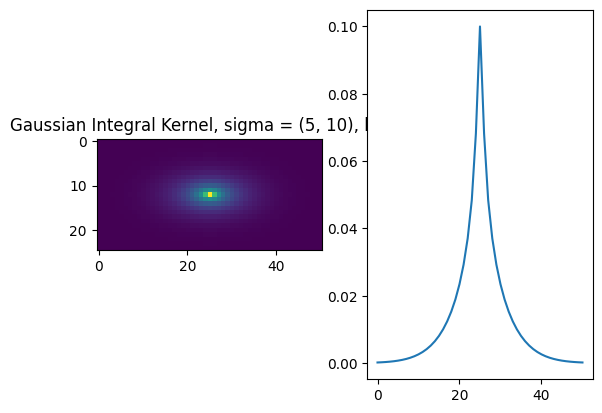

(3,)


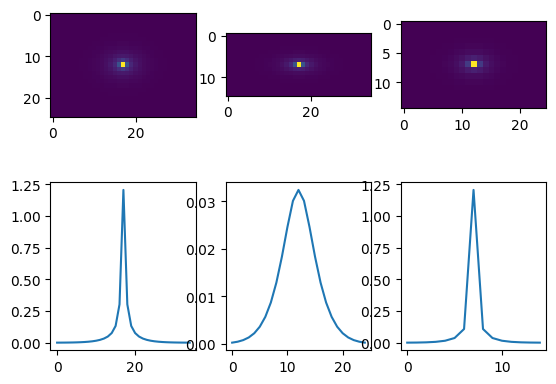

In [2]:
from scipy.special import exp1, erf

def build_x(sigma, kernel_size = None) -> torch.Tensor:
    dx = 1  # pixel size
    if kernel_size is None:
        s = 5
        
        kernel_size = [
            max(s, int(sig * s / dx)) + (1 - max(s, int(sig * s / dx)) % 2)
            for sig in sigma
        ]
    arr_list = [
        np.arange(ks, dtype=np.float32) - (ks // 2)
        for ks in kernel_size
    ]
    mesh = tuple(
        list(
            np.meshgrid(*arr_list, indexing='ij')
         )#[::-1]  # reverse the order of the list
    )
    x = np.stack(mesh, axis = -1)
    
    x[x==0] = 1e-6
    return x

def build_kernel_2d(sigma, k, kernel_size = None) -> torch.Tensor:
    def norm(x):
        # return np.abs(x).sum(axis = -1)**2
        return np.sum(x**2,axis = -1)
    
    if sigma is not np.ndarray:
        sigma = np.array(sigma)
    print(sigma.shape)
    if sigma.shape[0] != 2:
        raise ValueError("sigma must be a 2 elements vector")

    x = build_x(sigma,  kernel_size)
    norm_x = norm(x / sigma[None,None]) / 2
    
    vol = np.prod(sigma)
    exp1_1 = exp1(norm_x)
    exp1_2 = exp1(norm_x * 2**(2 * (k + 1) ))
    print(np.isnan(exp1_1).sum(),np.isnan(exp1_2).sum())
    exp1_diff =  exp1(norm_x) - exp1(norm_x * 2**(2 * (k + 1) ))
    
    return exp1_diff / (2 * log(2) * vol)
   
def build_kernel_3d(sigma, k, kernel_size = None) -> torch.Tensor:
    def norm(x):
        # return np.abs(x).sum(axis = -1)**2
        return np.sqrt(np.sum(x**2,axis = -1))
    
    if sigma is not np.ndarray:
        sigma = np.array(sigma)
    print(sigma.shape)
    if sigma.shape[0] != 3:
        raise ValueError("sigma must be a 3 elements vector")

    x = build_x(sigma,  kernel_size)
    norm_x = norm(x / sigma[None,None]) / sqrt(2)
    
    diff_erf = erf(norm_x * 2**(k + 1)) - erf(norm_x)
    vol = np.prod(sigma)

    return np.sqrt(2 *  np.pi) *  diff_erf / ( log(2) * vol * norm_x) 

sigma = (5,10)
k = 4
kernel_2d = build_kernel_2d(sigma, k)

fig,ax = plt.subplots(1,2)
h,w = kernel_2d.shape
a = ax[0].imshow(kernel_2d)
ax[1].plot(kernel_2d[h//2], label = f'k = {k}')
    
ax[1].plot(kernel_2d[h//2,w//2], label = f'k = {k}')
ax[0].set_title(f'Gaussian Integral Kernel, sigma = {sigma}, k = {k}')
plt.show()


sigma = (3,5,7)
kernel_3d = build_kernel_3d(sigma, k)

fig,ax = plt.subplots(2,3)
h,w,c = kernel_3d.shape
a = ax[0,0].imshow(kernel_3d[h//2])
ax[0,1].imshow(kernel_3d[:,w//2])
ax[0,2].imshow(kernel_3d[:,:,c//2])

ax[1,0].plot(kernel_3d[h//2, w//2], label = f'k = {k}')
ax[1,1].plot(kernel_3d[h//2, :, w//2], label = f'k = {k}')
ax[1,2].plot(kernel_3d[:,w//2, c//2], label = f'k = {k}')
plt.show()


(2,)
0 0
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([15, 30]),
	sigma_continuous=tensor([15, 30]),
	 k=3,
	 dx=(1, 1),
	 kernel_size=torch.Size([1, 75, 151])
)


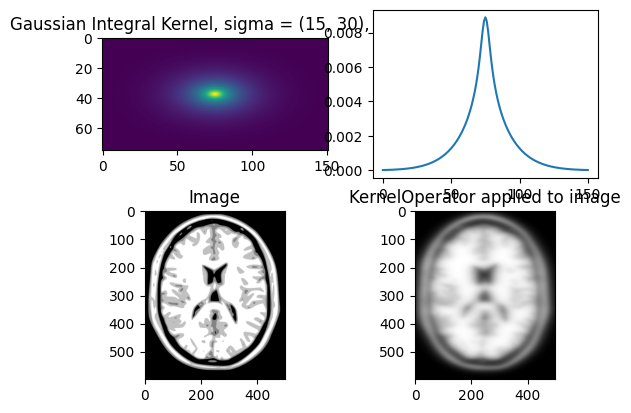

(3,)
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([3, 5, 7]),
	sigma_continuous=tensor([3, 5]),
	 k=3,
	 dx=(1, 1),
	 kernel_size=torch.Size([1, 15, 25, 35])
)
(3,)


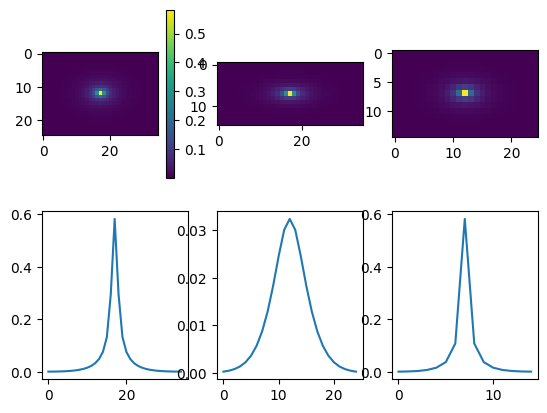

In [19]:
class All_Scale_Anisotropic_Normalized_Gaussian_RKHS(torch.nn.Module):

    def __init__(self,
                 sigma,
                 k,
                 dx,
                 kernel_size = None,
                 sigma_convention = 'pixel'
                 ):
        super(All_Scale_Anisotropic_Normalized_Gaussian_RKHS, self).__init__()
        self.dx = dx
        if sigma_convention == 'pixel':
            self.sigma = torch.tensor(sigma)
            self.sigma_continuous = torch.tensor(
                [s*d for d,s in zip(self.dx, sigma)]
            )
        elif sigma_convention == 'continuous':
            self.sigma_continuous = torch.tensor(sigma)
            self.sigma = torch.tensor(
                [s/d for d,s in zip(self.dx, sigma)]
            )
        else:
            raise ValueError("argument sigma_convention must be 'pixel' or 'continuous'"
                             f"got {sigma_convention}")
        self._dim = len(sigma)
        self.k = k
        self.kernel_size = kernel_size
        if self._dim == 2:
            self.kernel = torch.Tensor(self._build_kernel_2d(self.sigma.numpy(), k, kernel_size))[None]
        elif self._dim == 3:
            self.kernel = torch.Tensor(self._build_kernel_3d(self.sigma.numpy(), k, kernel_size))[None]
        else:
            raise NotImplementedError("Only 2D and 3D are supported")
        
        self.filter = rk.fft_filter
        self.kwargs_filter = {'border_type':'constant',
                              }
        
    def init_kernel(self,image):
        if isinstance(self.sigma, tuple) and len(self.sigma) != len(image.shape[2:]) :
            raise ValueError(f"kernelOperator :{self.__class__.__name__}"
                             f"was initialised to be {len(self.sigma)}D"
                             f" with sigma = {self.sigma} and got image "
                             f"source.size() = {image.shape}"
                             )
        self.sigma_continuous = self.sigma_continuous.to(image.device)
        self.sigma = self.sigma.to(image.device)

    def get_all_arguments(self):
        return {
            'name':self.__class__.__name__,
            'sigma':self.sigma,
            'k':self.k,
            'kernel_size':self.kernel_size
        }

    def __repr__(self):
        return (f"{self.__class__.__name__}+\
            (\n\tsigma={self.sigma},"
                f"\n\tsigma_continuous={self.sigma_continuous},"
                f"\n\t k={self.k},"
                f"\n\t dx={self.dx},"
                f"\n\t kernel_size={self.kernel.shape}\n)")
    
    def _build_x_(self, sigma, kernel_size = None) -> torch.Tensor:
        dx = 1  # pixel size
        if kernel_size is None:
            s = 5
            
            kernel_size = [
                max(s, int(sig * s / dx)) + (1 - max(s, int(sig * s / dx)) % 2)
                for sig in sigma
            ]
        arr_list = [
            np.arange(ks, dtype=np.float32) - (ks // 2)
            for ks in kernel_size
        ]
        mesh = tuple(
            list(
                np.meshgrid(*arr_list, indexing='ij')
             )#[::-1]  # reverse the order of the list
        )
        x = np.stack(mesh, axis = -1)
    
        x[x==0] = 1e-6
        return x
    
    def     _build_kernel_2d(self,sigma, k, kernel_size = None) -> torch.Tensor:
        def norm(x):
            # return np.abs(x).sum(axis = -1)**2
            return np.sum(x**2,axis = -1)
        
        if sigma is not np.ndarray:
            sigma = np.array(sigma)
        print(sigma.shape)
        if sigma.shape[0] != 2:
            raise ValueError("sigma must be a 2 elements vector")
    
        x = self._build_x_(sigma,  kernel_size)
        norm_x = norm(x / sigma[None,None]) / 2
        
        vol = np.prod(sigma)
        exp1_1 = exp1(norm_x)
        exp1_2 = exp1(norm_x * 2**(2 * (k + 1) ))
        print(np.isnan(exp1_1).sum(),np.isnan(exp1_2).sum())
        exp1_diff =  exp1(norm_x) - exp1(norm_x * 2**(2 * (k + 1) ))
        
        return exp1_diff / (2 * log(2) * vol)
   
    def _build_kernel_3d(self, sigma, k, kernel_size = None) -> torch.Tensor:
        def norm(x):
            # return np.abs(x).sum(axis = -1)**2
            return np.sqrt(np.sum(x**2,axis = -1))
        
        if sigma is not np.ndarray:
            sigma = np.array(sigma)
        print(sigma.shape)
        if sigma.shape[0] != 3:
            raise ValueError("sigma must be a 3 elements vector")
    
        x = self._build_x_(sigma,  kernel_size)
        norm_x = norm(x / sigma[None,None]) / sqrt(2)
        
        diff_erf = erf(norm_x * 2**(k + 1)) - erf(norm_x)
        vol = np.prod(sigma)
    
        return np.sqrt(2 *  np.pi) *  diff_erf / ( log(2) * vol * norm_x) 

    def forward(self, input):
        """
        Convolve the input tensor with the  kernel.

        Args:
        -------
        input (torch.Tensor):
            the input tensor with shape of :math:`(B, C, H, W)` or :math:`(B, C, D, H, W)`

        Returns:
        -----------
        torch.Tensor: the convolved tensor of same size and numbers of channels as the input.
        """

        if (self._dim == 2 and len(input.shape) == 4) or (self._dim == 3 and len(input.shape) == 5):
            view_sig = (1,-1) + (1,)*(len(input.shape)-2)
            # input *= self.sigma_continuous.to(input.device).view(view_sig)**2
            convol = self.filter(input,self.kernel,**self.kwargs_filter)
            convol *= self.sigma.to(input.device).view(view_sig)**2
            return convol
        else:
            raise ValueError(f"{self.__class__.__name__} was initialized "
                             f"with a {self._dim}D mask and input shape is : "
                             f"{input.shape}")
        
def test_MSANG_2d():
    sigma = (15,30)
    k = 3
    
    dx = (1,1)
    kernelOperator = All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
            sigma=sigma,
            k = k,
            dx=dx,
            sigma_convention='pixel'
        )
    
    print(kernelOperator)
    image =tb.reg_open('b0')
    kernelOperator.init_kernel(image)
    kernel_2d = kernelOperator.kernel[0].cpu()
    k_im = kernelOperator(
        image.repeat(1,2,1,1)
    )
    
    fig,ax = plt.subplots(2,2)
    h,w = kernel_2d.shape
    a = ax[0,0].imshow(kernel_2d)
    ax[0,1].plot(kernel_2d[h//2], label = f'k = {k}')
        
    ax[0,1].plot(kernel_2d[h//2,w//2], label = f'k = {k}')
    ax[0,0].set_title(f'Gaussian Integral Kernel, sigma = {sigma}, k = {k}')
    
    ax[1,0].imshow(image[0,0],'gray')
    ax[1,0].set_title(f'Image')
    ax[1,1].imshow(k_im[0,0],'gray')
    ax[1,1].set_title(f'KernelOperator applied to image')
    plt.show()
    
    
def test_MSANG_3d():
    sigma = (3,5,7)
    k = 3
    
    dx = (1,1)
    kernelOperator = All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
            sigma=sigma,
            k = k,
            dx=dx,
            sigma_convention='pixel'
        )
    
    print(kernelOperator)
    
    # kernelOperator.init_kernel(image)
    
    kernel_3d = build_kernel_3d(sigma, k)

    fig,ax = plt.subplots(2,3)
    h,w,c = kernel_3d.shape
    a = ax[0,0].imshow(kernel_3d[h//2])
    fig.colorbar(a, ax=ax[0,0])
    ax[0,1].imshow(kernel_3d[:,w//2])
    ax[0,2].imshow(kernel_3d[:,:,c//2])
    
    ax[1,0].plot(kernel_3d[h//2, w//2], label = f'k = {k}')
    ax[1,1].plot(kernel_3d[h//2, :, w//2], label = f'k = {k}')
    ax[1,2].plot(kernel_3d[:,w//2, c//2], label = f'k = {k}')
    
test_MSANG_2d()
test_MSANG_3d()

# Experiences 

In [42]:

def tp(x):
    """ prepare simplex tensor to be plotted as an image
    
    """
    tp_img = x[0].permute(1,2,0).cpu().numpy()
    if tp_img.shape[-1] in [3,4]:
        return tp_img
    elif tp_img.shape[-1] == 2:
        z_shape = tp_img.shape[:-1]
        zero = np.zeros(z_shape + (1,))
        return np.concatenate(
            [tp_img,zero],axis=-1
        )
    
def to_plot(img):
    if img.shape[-1] == 3:
        return img
    elif img.shape[-1] == 4:
        return img[...,:-1]

def make_exp(xxx, yyy, centre, sigma):
    ce_x, ce_y = centre
    sigma_x,sigma_y = sigma
    exp = torch.exp(
        - 0.5*((xxx - ce_x) / sigma_x) ** 2
        - 0.5*((yyy - ce_y) / sigma_y) ** 2)
    return exp


## Residual métric
        
def get_deformator(mp,from_t=0,to_t=None,save=False):
    temporal_integrator = vff.FieldIntegrator(method='temporal',save=save)
    if from_t is None and to_t is None:
        print('Je suis passé par là')
        return temporal_integrator(mp.field_stock/mp.n_step, forward=False)
    # if from_t is None: from_t = 0
    if to_t is None: to_t = mp.n_step 
    if from_t < 0 and from_t >= to_t: 
        raise ValueError(f"from_t must in [0,n_step-1], got from_t ={from_t} and n_step = {mp.n_step}")
    if to_t > mp.n_step: 
        raise ValueError(f"to_t must in [from_t+1,n_step], got to_t ={to_t} and n_step = {mp.n_step}")
    if to_t==1:
        return mp.id_grid.detach().cpu() - mp.field_stock[0][None].detach().cpu() / mp.n_step
    # ic(from_t,to_t,mp.field_stock[from_t:to_t].shape)
    return temporal_integrator(mp.field_stock[from_t:to_t]/mp.n_step, forward=False)
    
# Plot visu registration:
def get_resi_cumul_onTarget(mr, debug = False ) :
    resi_sum = torch.zeros_like(mr.target)
    N = mr.mp.residuals_stock.shape[0]
    if debug:
        fig,ax = plt.subplots(2,N,figsize=(5*N,10),constrained_layout=True)
    
    for i in range(N):
        deform_t = get_deformator(mr.mp,from_t=i,save=False)
        # ic(mr.mp.residuals_stock[i].min(),mr.mp.residuals_stock[i].max())
        resi_sum += sqrt(1 - mr._get_rho_()) * tb.imgDeform(mr.mp.residuals_stock[i][None], deform_t,dx_convention=mr.dx_convention) / mr.mp.n_step
        # ic(resi_sum.min(),resi_sum.max())
        if debug:
            to_show_r = resi_sum.squeeze().permute(1,2,0).numpy()
            ax[0,i].imshow(to_show_r[...,:-1])
            ax[1,i].imshow(mr.mp.residuals_stock[i].squeeze().permute(1,2,0).numpy()[...,:-1])
            set_ticks_off(ax)
    return resi_sum    
    
def residual_quality_metric(mr,resi_rhoInfty):
    resi_sum = get_resi_cumul_onTarget(mr,debug=False)
    return torch.sum((resi_sum - resi_rhoInfty ) ** 2)
    
def plot_endresult(mr,save=False, return_all=False,filename=None):
    image_ts = tp(mr.mp.image) **2
    # momentum_ts = mr.mp.momentum.permute(0,2,3,1).squeeze().cpu().detach().numpy()
    momentum_ts = tp(mr.mp.momentum)    
    
    # ic(image_ts.shape)
    residual_cumul = get_resi_cumul_onTarget(mr,debug=False)#.cpu().permute(0,2,3,1)[0]
    # print('residual_cumul.shape:',residual_cumul.shape)
    # residual_cumul = residual_cumul.sum(dim=-1)
    # residual_cumul = residual_cumul
    #residual_ts = mr.mp.residuals.squeeze().permute(1,2,0).numpy() 
    
    deform = mr.mp.get_deformation()
    # print("source dtype",source.dtype)
    # print("deformator",mr.mp.get_deformator().dtype)
    im_deformed_only = tb.imgDeform(source.to('cpu'),mr.mp.get_deformator().cpu(),dx_convention=mr.dx_convention)
    im_deformed_only = tp(im_deformed_only) 
    
    diff_im_t = np.sum(np.abs(image_ts-tp(target)),axis=-1)
    diff_im_def = np.sum(np.abs(im_deformed_only-tp(target)),axis=-1)

    metric_ssd = np.sqrt(np.sum((image_ts-tp(target))**2))
    metric_sdd_def_only = np.sqrt(np.sum((im_deformed_only-tp(target))**2))

    fig,ax = plt.subplots(3,3,figsize=(10,10),constrained_layout=True)
    fig.suptitle(mr.mp, fontsize=16)
    ax[0,0].imshow(tp(source))
    ax[0,0].set_title("Source")
    ax[0,1].imshow(tp(target))
    ax[0,1].set_title("Target")
    
    step = max(1,deform.shape[1]//15)
    tb.gridDef_plot_2d(deform,step=step,ax=ax[0,2],check_diffeo=True,origin = 'upper')
    
    
    ax[1,1].imshow(image_ts)
    ax[1,1].set_title("Image")
    ax[1,0].imshow(momentum_ts)
    ax[1,0].set_title("Momentum")
    # ic(residual_cumul.shape)
    # ic(residual_cumul.dtype)
    d = ax[1,2].imshow(tp(residual_cumul))
    fig.colorbar(d, ax=ax[1,2])
    ax[1,2].set_title("Cumulative residual")
    
    ax[2,0].imshow(im_deformed_only)
    ax[2,0].set_title(f"only Deformed Source")
    d = ax[2,1].imshow(diff_im_t,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,1])
    ax[2,1].set_title(f"Diff Image Target = {metric_ssd:.2f}")
    d = ax[2,2].imshow(diff_im_def,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,2])
    ax[2,2].set_title(f"Diff Image only deformed m = {metric_sdd_def_only:.2f}")
    
    
    set_ticks_off(ax)
    if save:
        if filename is None:
            filename = f"{path_save}{name}_{mr.mp.kernelOperator.sigma_continuous.tolist()}_summary.png"
        else:
            filename = f"{path_save}{filename}.png"
        plt.savefig(filename)
    
    if return_all:
        return {"metric_ssd" : metric_ssd,
                "metric_sdd_def_only" : metric_sdd_def_only,
                "im_deformed_only" : im_deformed_only,
                "image_ts" : image_ts,
                "momentum_ts" : momentum_ts,
                "residual_cumul" : residual_cumul
                }
    else:
        return metric_ssd,metric_sdd_def_only
    
device = 'cuda:0'

def experience_2(size,sigma):
    H,W = size
    
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
    
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    centre = (0.5,0.5)
    boule = (xx - centre[0])**2 + (yy - centre[1])**2 < 0.2**2
    image[0,0] = boule
    image[0,1] = torch.logical_not(boule)
    
    moving = image.clone()
    
    # add exps
    sigma_exp1 = (sigma,sigma)    # centre = (0.5,0.5)

    sigma_exp2 = (sigma,sigma)
    exp = make_exp(xx,yy,(.6,.5),sigma_exp1) * .2
    # 
    newboule = (xx + exp - centre[0])**2 + (yy -exp - centre[1])**2 < 0.2**2
    image[0,0] = newboule
    # image[0,0] =1 - image[0,1]
    image[0,1] = torch.logical_not(newboule)
    fixed = image.clone()
    name = 'cst_border'
    return moving,fixed, name


def experience_3(size,sigma):
    H,W = size
   
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
   
    def th(u):
        return (1.0+(30.0*u).tanh())/2.
   
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = (xx >= .5)
    image[0,1] = (xx <.5)
    #image[0,0] = th(xx - .5)
    #image[0,1] = th(.5-  xx)
    print(image.max())
   
    moving = image.clone()
   
    # add exps
    sigma_exp1 = (0.3*sigma,0.3*sigma)
    sigma_exp2 = (2*sigma,sigma)
    exp = make_exp(xx,yy,(.5,.3),sigma_exp2)
    exp += make_exp(xx,yy,(.5,.7),sigma_exp1)
   
    image[0,1] = (xx-0.3*(1-yy)*(40*yy**2).sin())<.5
    image[0,0] =1 - image[0,1]
    fixed = image.clone()
    name = 'add_vol_sigma'
    return moving,fixed, name

def experience_3_bis(size, sigma, pad_size=0):
    H, W = size

    id_grid = tb.make_regular_grid((H, W), dx_convention='square')
    xx, yy = id_grid[0, ..., 0], id_grid[0, ..., 1]

    def th(u):
        return (1.0 + (30.0 * u).tanh()) / 2.

    # Initial image with 2 channels
    image = torch.zeros((1, 2, H, W))
    image[0, 0] = (xx >= .5)
    image[0, 1] = (xx < .5)

    moving = image.clone()

    # Add exponentials
    sigma_exp1 = (0.3 * sigma, 0.3 * sigma)
    sigma_exp2 = (2 * sigma, sigma)
    exp = make_exp(xx, yy, (.5, .3), sigma_exp2)
    exp += make_exp(xx, yy, (.5, .7), sigma_exp1)

    image[0, 1] = (xx - 0.3 * (1 - yy) * (40 * yy**2).sin()) < .5
    image[0, 0] = 1 - image[0, 1]
    fixed = image.clone()

    if pad_size > 0:
        # Add padding to spatial dims (top, bottom, left, right)
        pad = (pad_size, pad_size, pad_size, pad_size)  # (left, right, top, bottom)

        # Pad moving and fixed for the first 2 channels
        moving = torch.nn.functional.pad(moving, pad, mode='constant', value=0)
        fixed = torch.nn.functional.pad(fixed, pad, mode='constant', value=0)

        # Add 3rd channel with black padding: 1 inside pad, 0 elsewhere
        _, _, H_pad, W_pad = fixed.shape
        channel_pad = torch.zeros((1, 1, H_pad, W_pad), dtype=fixed.dtype)

        channel_pad[:, :, :pad_size, :] = 1
        channel_pad[:, :, -pad_size:, :] = 1
        channel_pad[:, :, :, :pad_size] = 1
        channel_pad[:, :, :, -pad_size:] = 1

        # Concatenate as third channel
        moving = torch.cat([moving, channel_pad], dim=1)
        fixed = torch.cat([fixed, channel_pad], dim=1)

    name = 'add_vol_sigma'
    return moving, fixed, name


def experience_4(size):
    H,W = size
    target = torch.zeros((1,2,H,W))
    
    target_im = tb.reg_open('26', size)
    target[0,0] =  target_im[0,0]
    target[0,1] = 1 - target_im[0,0]
    
    source = torch.zeros((1,2,H,W))
    source_im = tb.reg_open('08', size)
    source[0,0] = source_im[0,0]
    source[0,1] = 1 - source_im[0,0]
    
    name = 'ink_drop'
    return source,target,name


### Open images

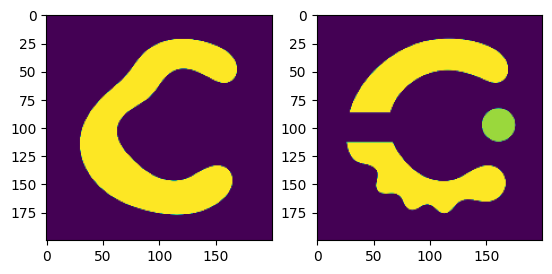

In [80]:
size = (200,200)
source = tb.reg_open('m0t', size=size)
target = tb.reg_open('m1cd', size=size)


fig,ax = plt.subplots(1,2)
ax[0].imshow(source[0,0])
ax[1].imshow(target[0,0])
# ax[2].imshow((boule - newboule)[0,0])
plt.show()


torch.Size([1, 3, 260, 260])


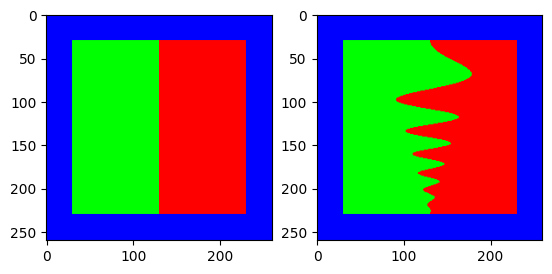

In [98]:
# source,target, name = experience_2((200,200),.08)

source,target, name = experience_3_bis((200,200),.08, pad_size=30)
# source,target, name = experience_4((200,200))
name = "all_scale_norm"
path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)
    
print(source.shape)
fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
# ax[2].imshow((boule - newboule)[0,0])
plt.show()

# 2. Registrations with differents RKHS

## 2.1 Simple Gaussian Kernel

In this example, we focus on registering the better we can the biggest bump.

GaussianRKHS,2D 
	filter :fft_filter, sigma :(27.897558341761513, 27.897558341761513)
	kernel_size :(1, 167, 167)
	kernel_reach :3
	normalized :False
kernel shape: torch.Size([1, 167, 167])
kernel shape: 167 167
x, y torch.Size([167, 167]) torch.Size([167, 167])


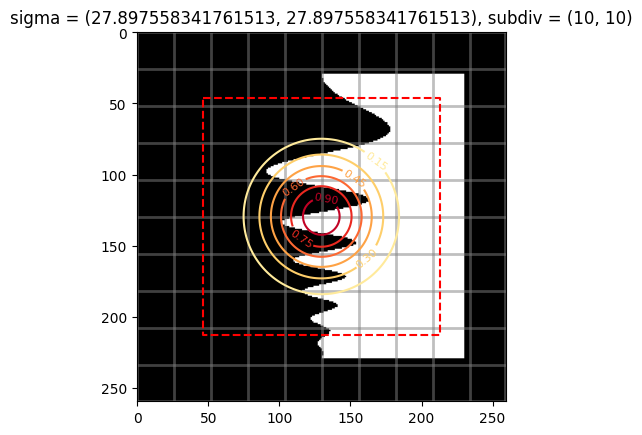

<Axes: title={'center': 'sigma = (27.897558341761513, 27.897558341761513), subdiv = (10, 10)'}>

In [99]:
subdiv = (10,10)
dx_convention = 'pixel' 
sigma = rk.get_sigma_from_img_ratio(source.shape,subdiv)

kernelOperator = rk.GaussianRKHS(sigma,
                                 # kernel_reach= 1,
                                 normalized=False,
                                 dx_convention = dx_convention,
                                 border_type='constant'
                                 )
print(kernelOperator)

rk.plot_kernel_on_image(kernelOperator,
                     subdiv = subdiv,
                     image = target,
                     # image_shape = (1,1,120,120)
                        )

### Simplex

Progress: [#---------]  10.00%  (Ssd : ,3112.3979).
Progress: [##--------]  15.00%  (Ssd : ,2915.5554).
Progress: [##--------]  20.00%  (Ssd : ,2846.8198).
Progress: [##--------]  25.00%  (Ssd : ,2836.7273).
Progress: [###-------]  30.00%  (Ssd : ,2803.0049).
Progress: [####------]  35.00%  (Ssd : ,2797.1555).
Progress: [####------]  40.00%  (Ssd : ,2791.1577).
Progress: [####------]  45.00%  (Ssd : ,2788.7161).
Progress: [#####-----]  50.00%  (Ssd : ,2786.9429).
Progress: [######----]  55.00%  (Ssd : ,2776.5356).
Progress: [######----]  60.00%  (Ssd : ,2775.8899).
Progress: [######----]  65.00%  (Ssd : ,2774.6995).
Progress: [#######---]  70.00%  (Ssd : ,2774.1680).
Progress: [########--]  75.00%  (Ssd : ,2773.6240).
Progress: [########--]  80.00%  (Ssd : ,2773.3687).
Progress: [########--]  85.00%  (Ssd : ,2773.5073).
Progress: [#########-]  90.00%  (Ssd : ,2772.7759).
Progress: [##########]  95.00%  (Ssd : ,2772.7441).
Progress: [##########] 100.00% Done...
 (Ssd : ,2772.7441).

Com

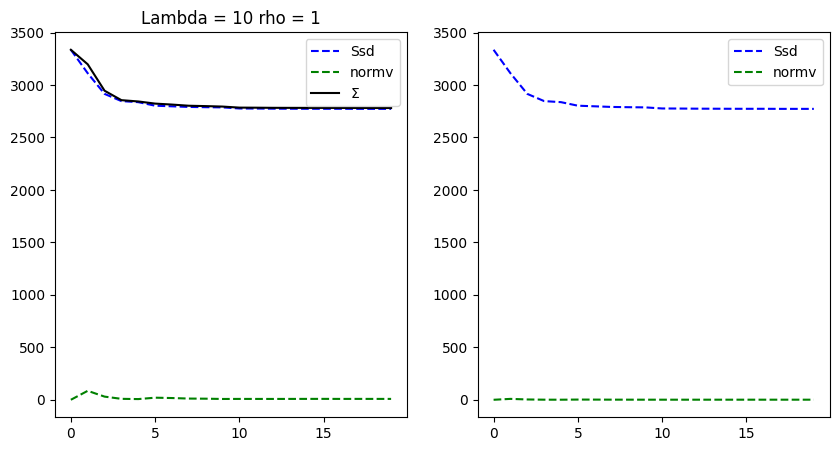

In [102]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
# data_cost = mt.Ssd_normalized(target)
data_cost =  None
ic.disable()

mr = mt.simplex_metamorphosis(source.clone(),target.clone(),momentum_ini,kernelOperator,rho,
                               integration_steps=10,
                               n_iter=20,
                               grad_coef=.2,
                               cost_cst=1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81886655..0.7768142].


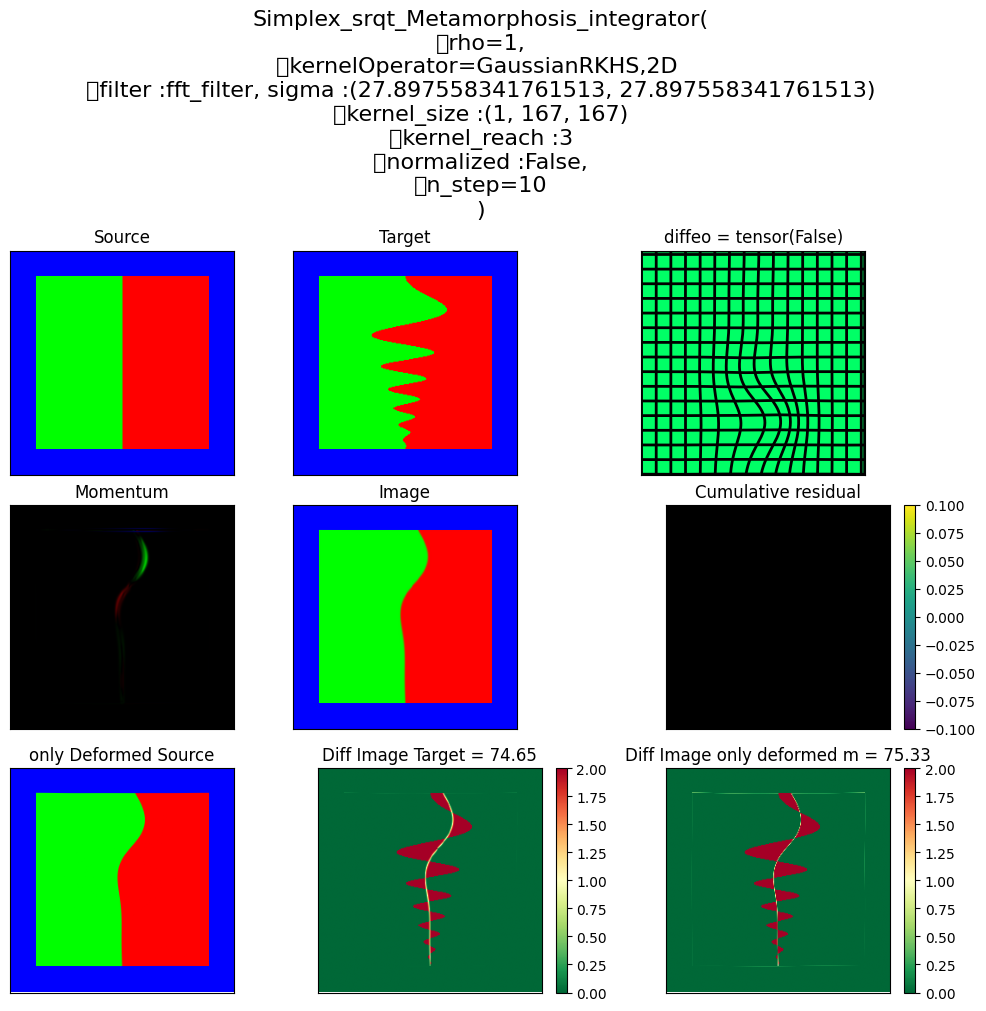

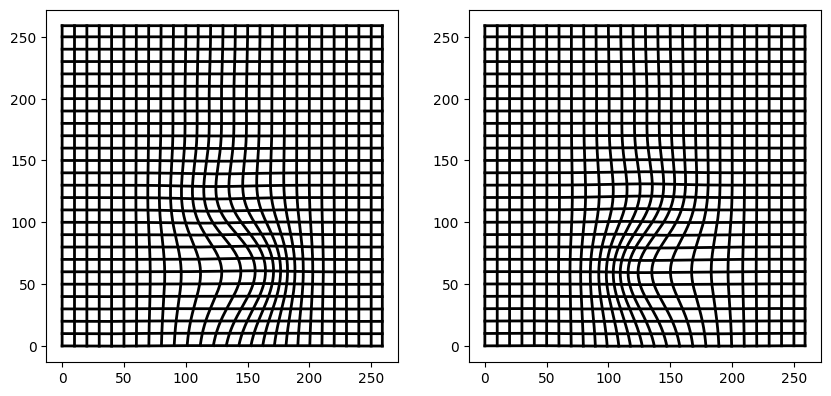

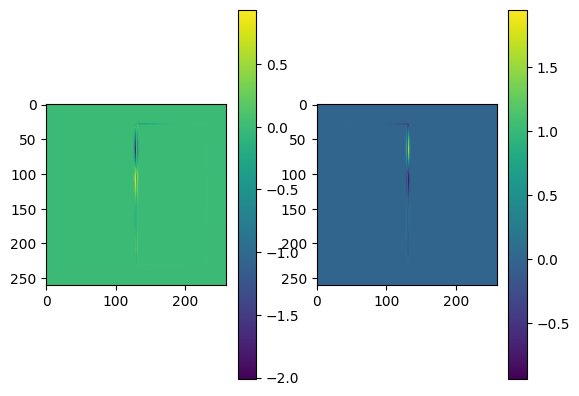

In [103]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2, figsize = (10,5))
tb.gridDef_plot_2d(mr.mp.get_deformation(), step= 10, ax =ax[0], color = 'black')
tb.gridDef_plot_2d(mr.mp.get_deformator(), step= 10, ax =ax[1], color = 'black')

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])

plt.show()



### gray scale image

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

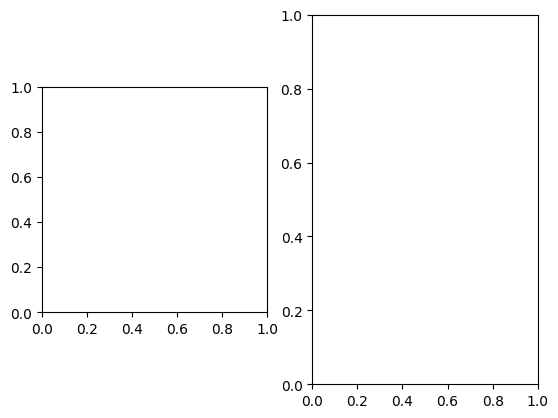

In [82]:
size = (200,200)
source = tb.reg_open('m0t', size=size)
target = tb.reg_open('m1cd', size=size)

source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)
fig,ax = plt.subplots(1,2)
ax[0].imshow(source[0,0],**DLT_KW_IMAGE)
ax[1].imshow(target[0,0],**DLT_KW_IMAGE)
# ax[2].imshow((boule - newboule)[0,0])
plt.show()


# data_cost = mt.Ssd_normalized(target)
data_cost = None
rho = 0.5
momentum_ini = torch.zeros_like(source)

mr = mt.metamorphosis(source,
                      target,
                      momentum_ini,
                      rho,
                      cost_cst=0.1,
                      kernelOperator = kernelOperator,
                      integration_steps=10, 
                      data_term = data_cost,
                      n_iter=10,
                        grad_coef=1,
                      )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21190127730369568..1.195237636566162].


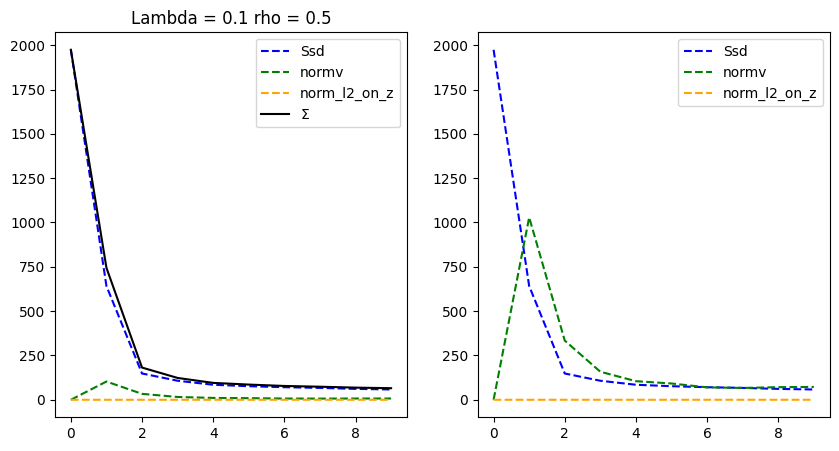

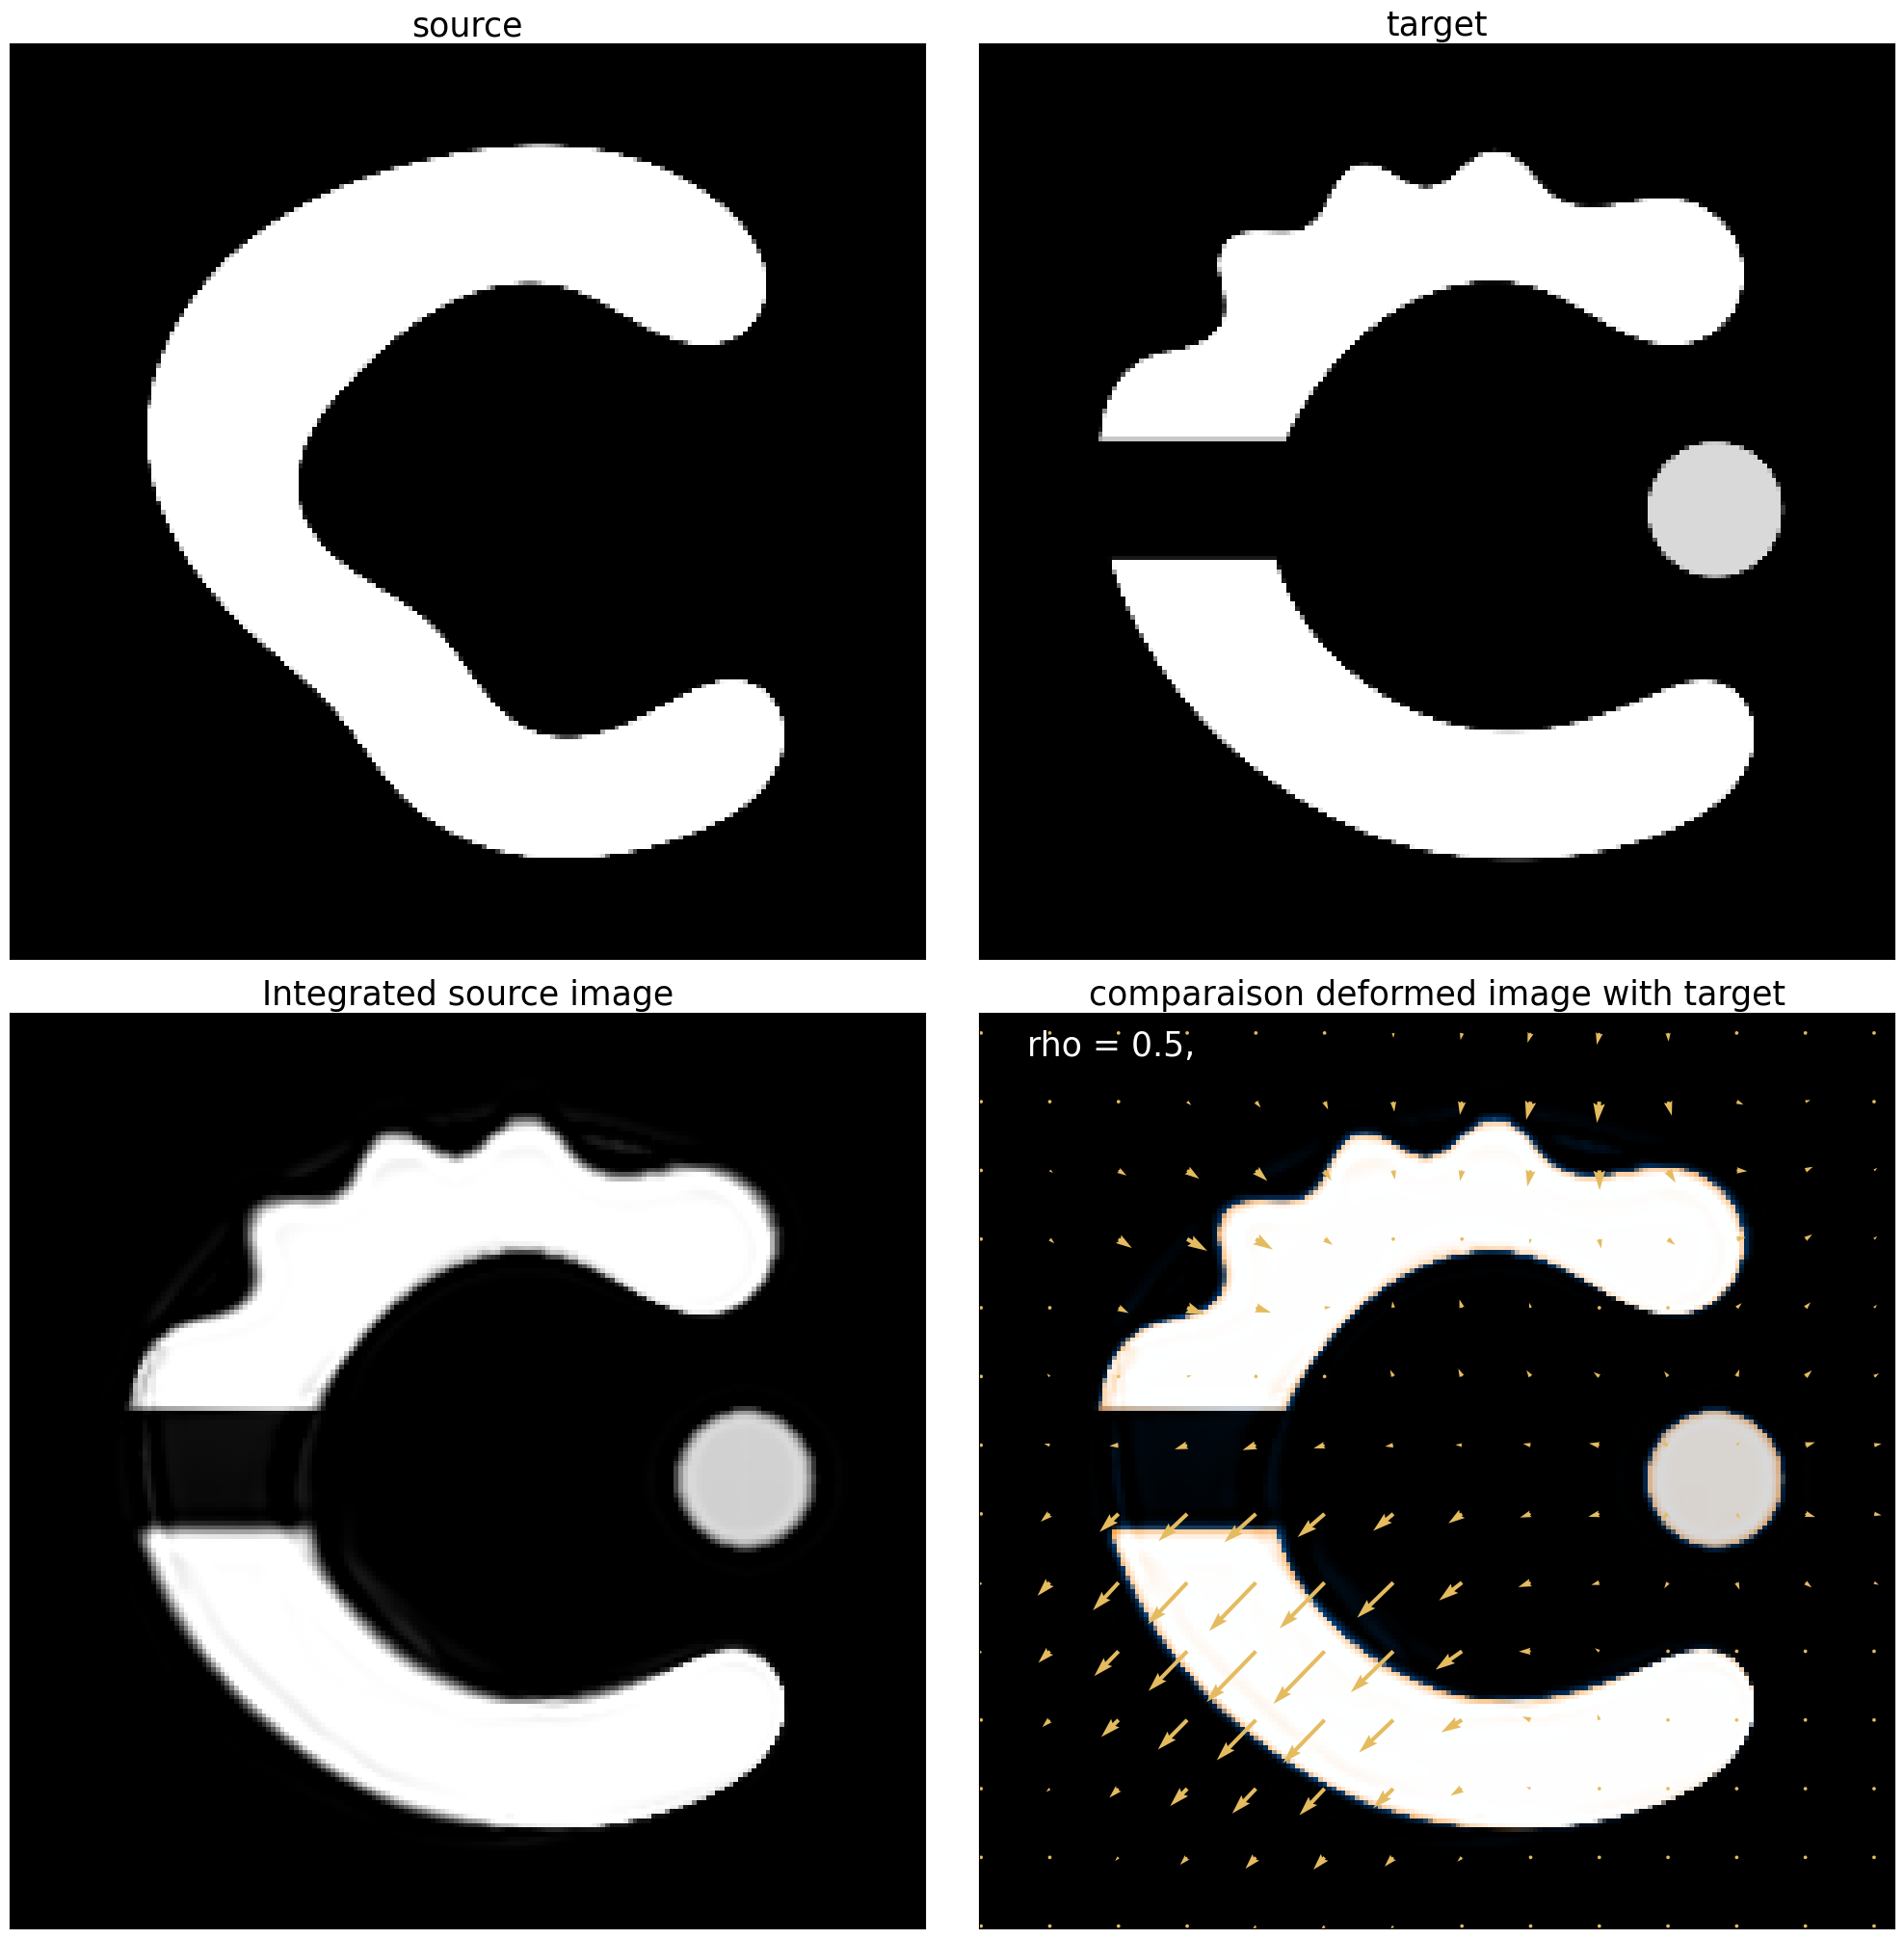

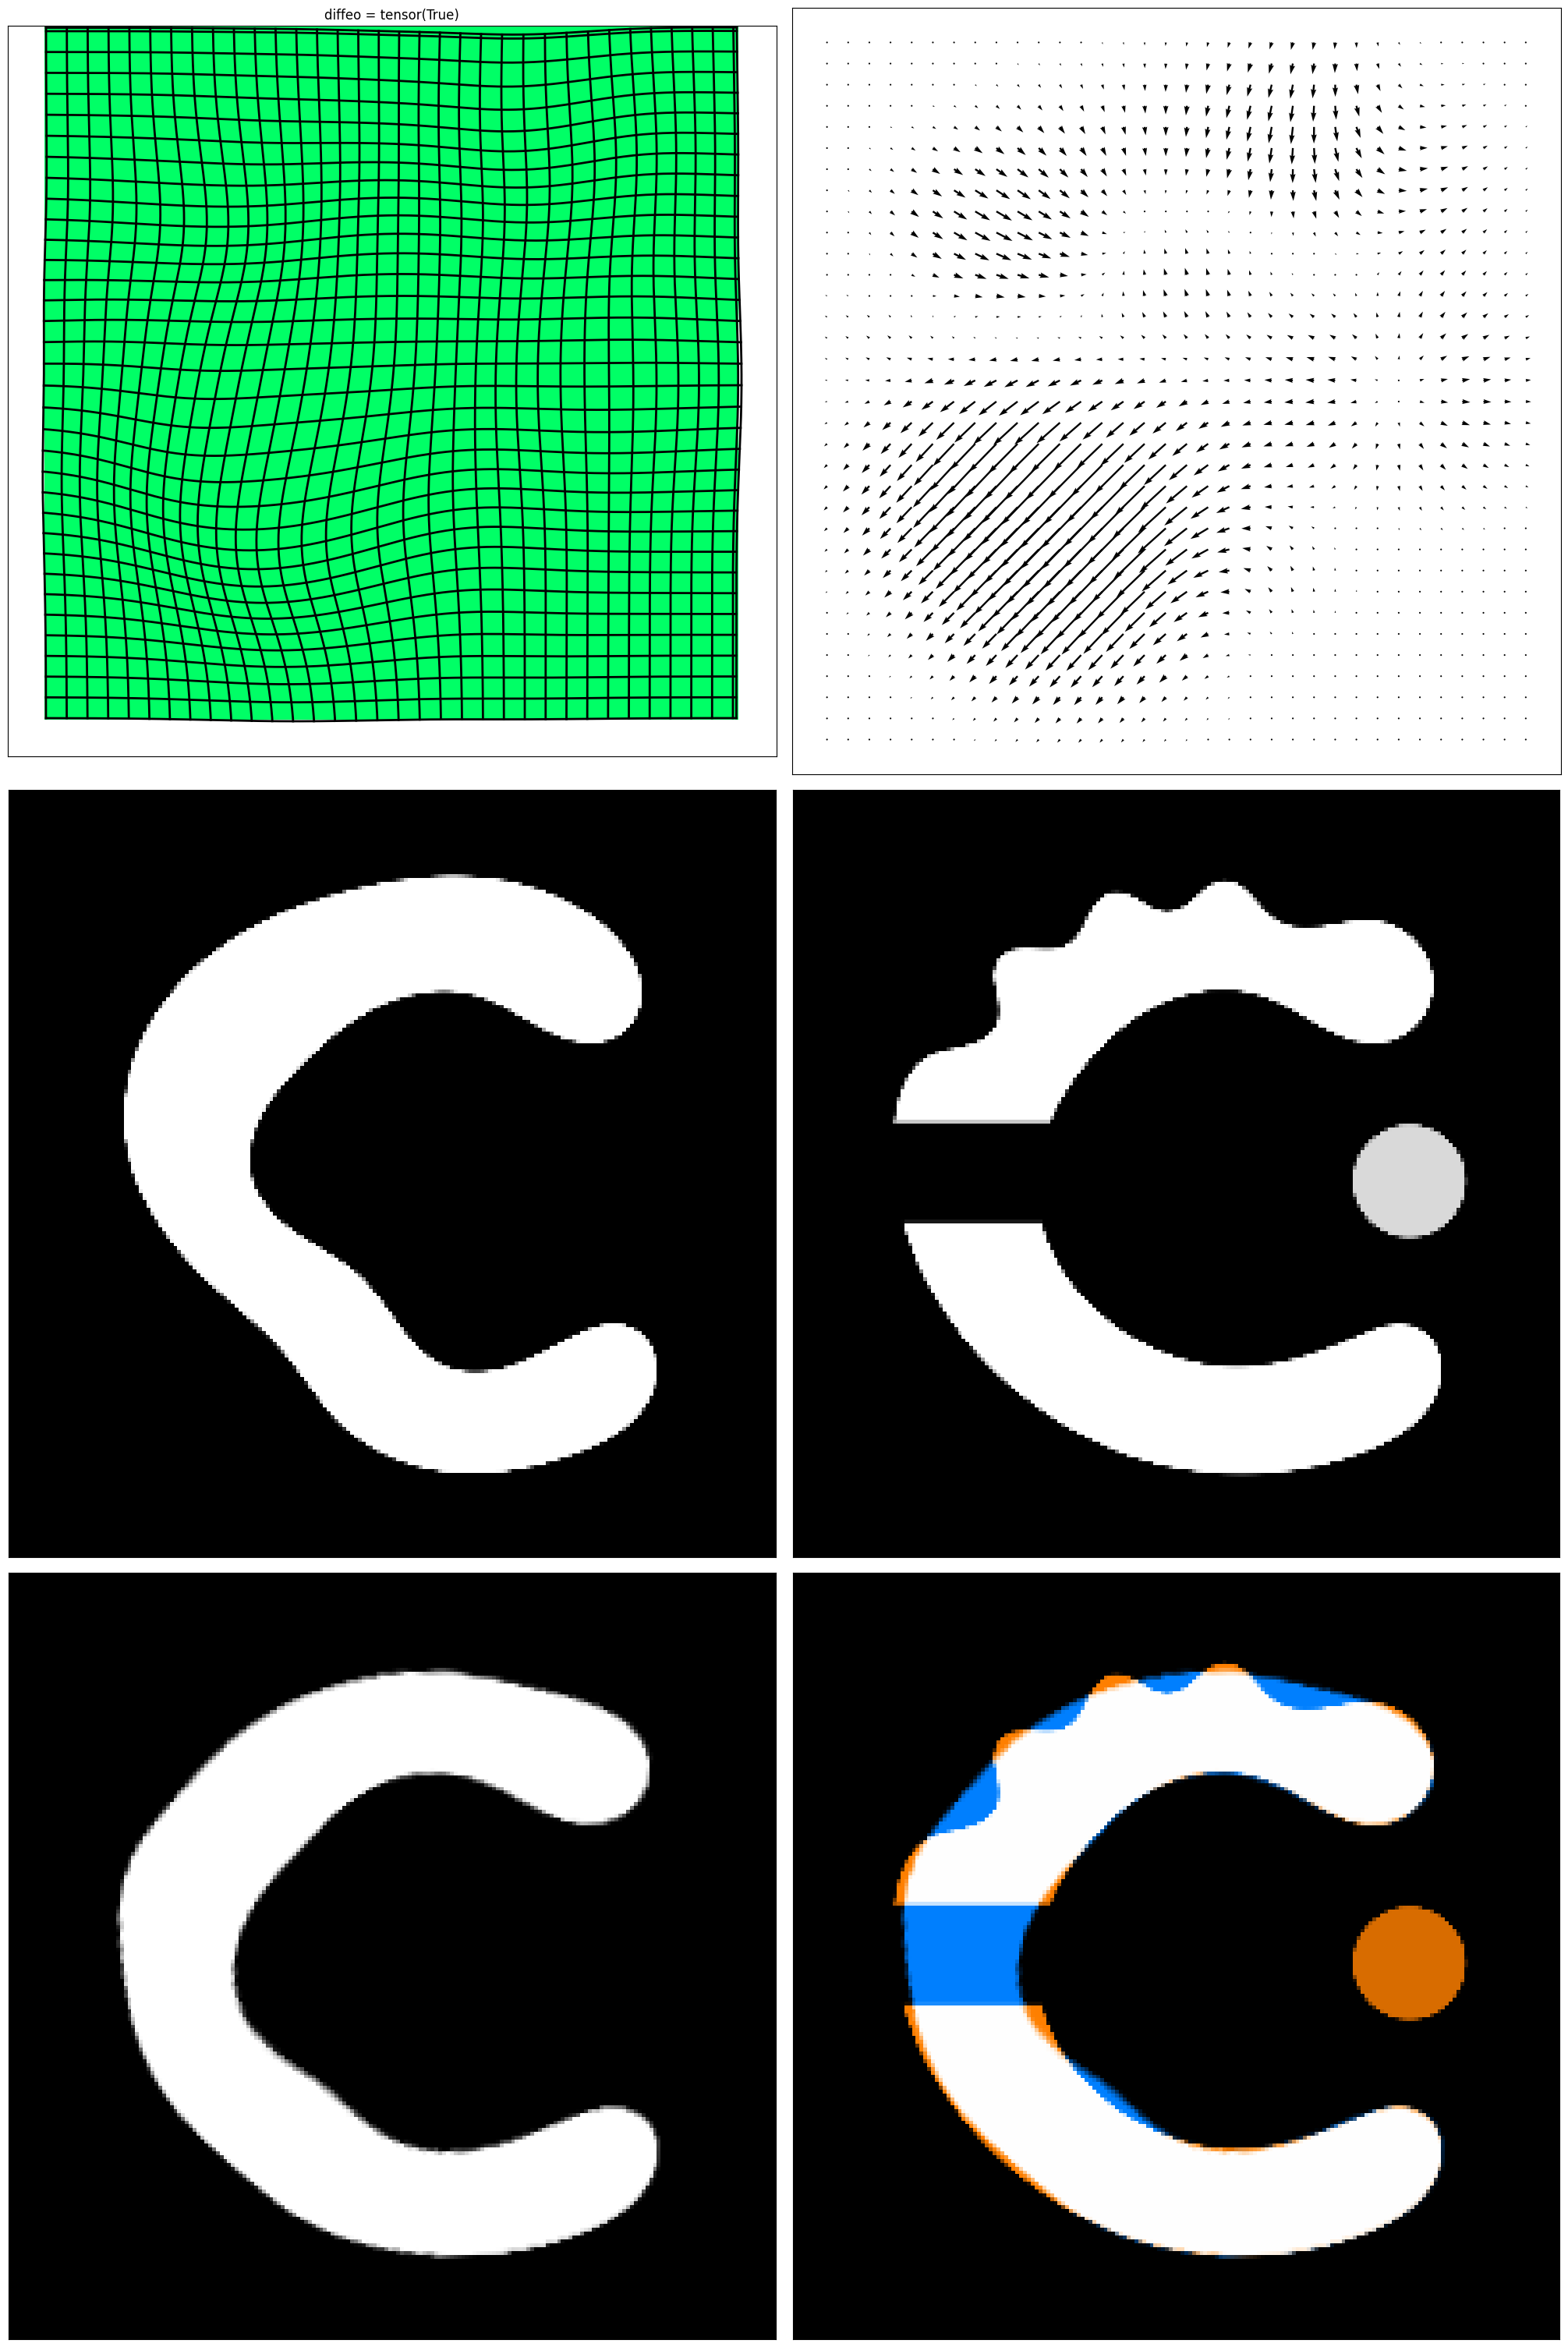

In [63]:
mr.plot()
mr.plot_deform()
plt.show()

## 2.2 Vol Normalised Gaussian Kernel 

with the same poorly choosen sigma



In [37]:
## New VolNormalizedGaussianRKHS version
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.07
# sigma = (s,s)
# sigma = (3,9)
kernelOperator = rk.VolNormalizedGaussianRKHS(
        sigma=sigma,
        sigma_convention='pixel', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        dx=dx,
        border_type='constant'
    )

(0.005025125628140704, 0.005025125628140704)


### Simplex

Progress: [#---------]  10.00%  (Ssd_normalized : ,  0.0417).
Progress: [##--------]  15.00%  (Ssd_normalized : ,  0.0309).
Progress: [##--------]  20.00%  (Ssd_normalized : ,  0.0271).
Progress: [##--------]  25.00%  (Ssd_normalized : ,  0.0249).
Progress: [###-------]  30.00%  (Ssd_normalized : ,  0.0210).
Progress: [####------]  35.00%  (Ssd_normalized : ,  0.0201).
Progress: [####------]  40.00%  (Ssd_normalized : ,  0.0181).
Progress: [####------]  45.00%  (Ssd_normalized : ,  0.0177).
Progress: [#####-----]  50.00%  (Ssd_normalized : ,  0.0168).
Progress: [######----]  55.00%  (Ssd_normalized : ,  0.0165).
Progress: [######----]  60.00%  (Ssd_normalized : ,  0.0160).
Progress: [######----]  65.00%  (Ssd_normalized : ,  0.0157).
Progress: [#######---]  70.00%  (Ssd_normalized : ,  0.0154).
Progress: [########--]  75.00%  (Ssd_normalized : ,  0.0153).
Progress: [########--]  80.00%  (Ssd_normalized : ,  0.0151).
Progress: [########--]  85.00%  (Ssd_normalized : ,  0.0151).
Progress

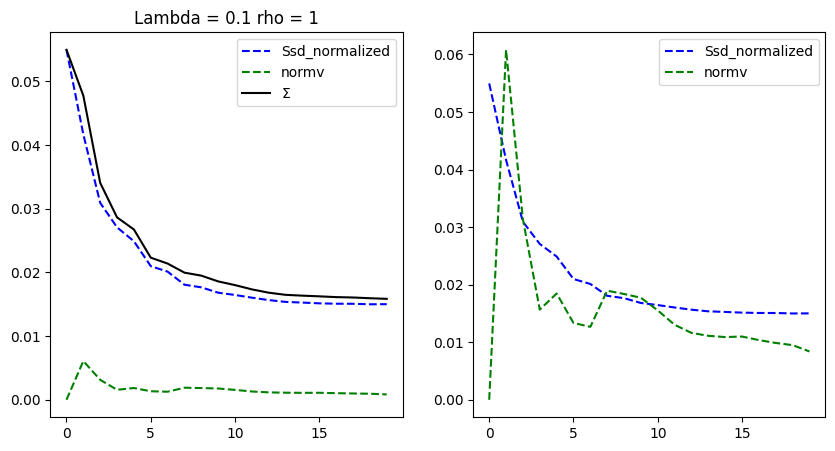

In [39]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
data_cost = mt.Ssd_normalized(target)
# data_cost =  None
ic.disable()

mr = mt.simplex_metamorphosis(source,target,momentum_ini,kernelOperator,rho,
                               integration_steps=10,
                               n_iter=20,
                               grad_coef=.2,
                               cost_cst=.1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030777636915445328..0.036010343581438065].


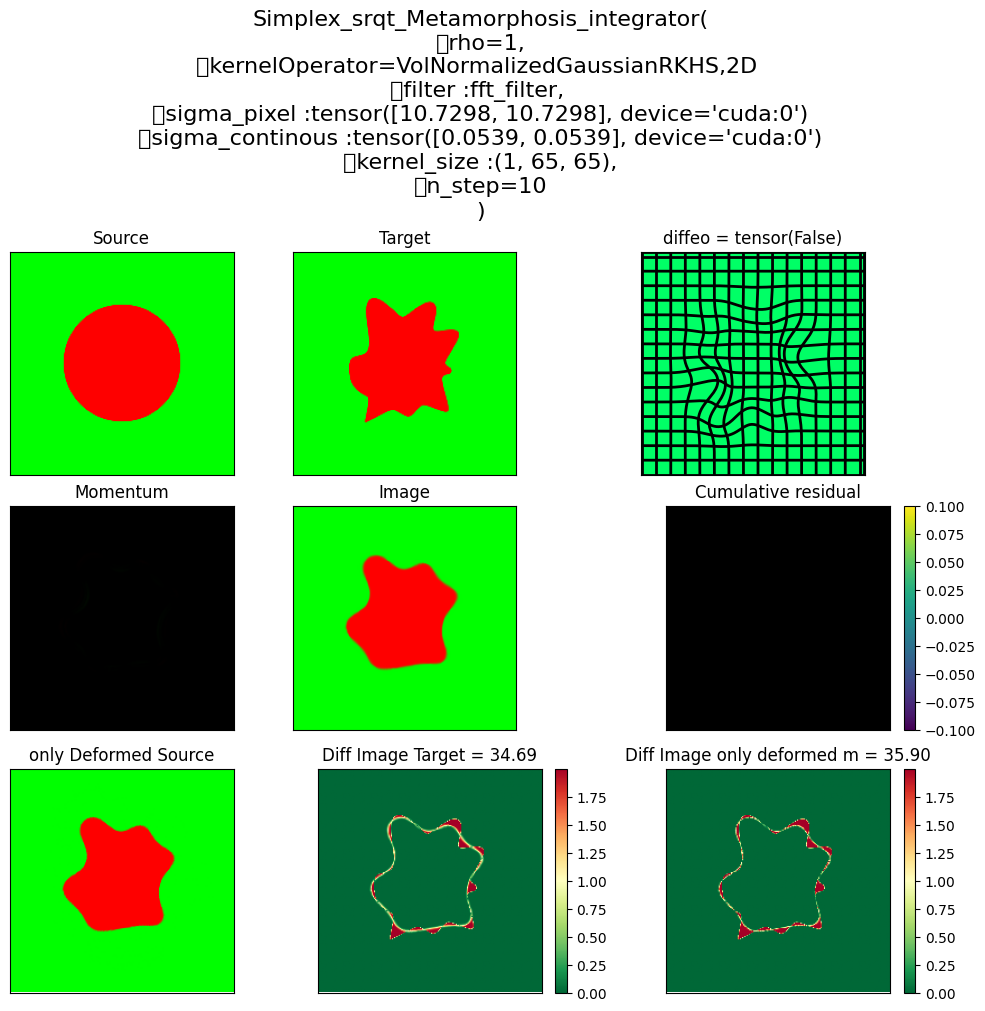

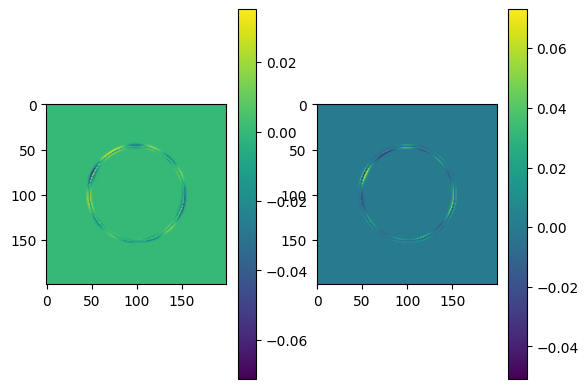

In [40]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])
plt.show()

### Gray scale image



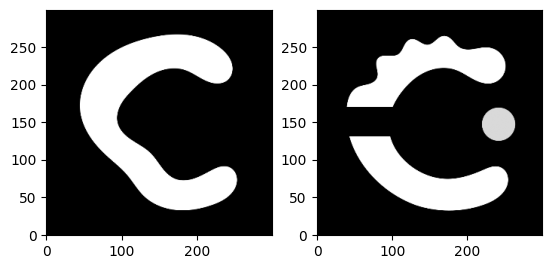

VolNormalizedGaussianRKHS,2D 
	filter :filter2d, 
	sigma_pixel :tensor([21.4597, 21.4597], device='cuda:0')
	sigma_continous :tensor([0.0718, 0.0718], device='cuda:0')
	kernel_size :(1, 257, 257)
Progress: [#---------]  10.00%  (Ssd_normalized : ,  0.0494).

KeyboardInterrupt: 

In [118]:
size = (300,300)
source = tb.reg_open('m0t', size=size)
target = tb.reg_open('m1cd', size=size)


fig,ax = plt.subplots(1,2)
ax[0].imshow(source[0,0],**DLT_KW_IMAGE)
ax[1].imshow(target[0,0],**DLT_KW_IMAGE)
# ax[2].imshow((boule - newboule)[0,0])
plt.show()

print(kernelOperator)
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)
data_cost = mt.Ssd_normalized(target)
# data_cost = None
rho = 0.5
momentum_ini = torch.zeros_like(source)

mr = mt.metamorphosis(source,
                      target,
                      momentum_ini,
                      rho,
                      cost_cst=0.1,
                      kernelOperator = kernelOperator,
                      integration_steps=5, 
                      data_term = data_cost,
                      n_iter=40,
                        grad_coef=.01,
                      )

mr.plot()
mr.plot_deform()
plt.show()

## 2.3  All scale Normalized Gaussian Kernel

with the same poorly choosen sigma

In [5]:
from math import prod




(0.003861003861003861, 0.003861003861003861)
(2,)
0 0
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([27.8976, 27.8976]),
	sigma_continuous=tensor([0.1077, 0.1077]),
	 k=4,
	 dx=(0.003861003861003861, 0.003861003861003861),
	 kernel_size=torch.Size([1, 139, 139])
)
kernel min max 2.9173631332923833e-07 0.006424475461244583
torch.Size([139, 139])


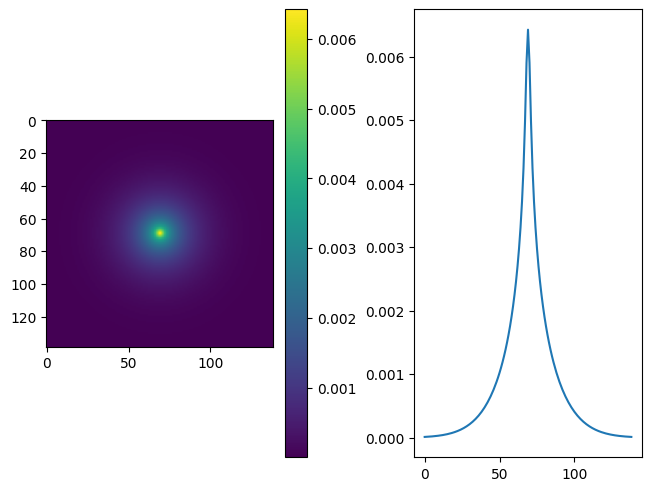

In [125]:
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.07
# sigma = (s,s)
# sigma = (3,9)
kernelOperator = rk.All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
        sigma=sigma,
        sigma_convention='pixel', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        k = 4,
        dx=dx,
    )
print(kernelOperator)

# image = kernelOperator(source.cpu())
# print("image min max",image.min(), image.max())

print("kernel min max",kernelOperator.kernel.min().item(), kernelOperator.kernel.max().item())
# print("diff min max :",kernelOperator.kernel.max().item() - kernelOperator.kernel.min().item())

kernel  = kernelOperator.kernel[0].cpu()
print(kernel.shape)
h,w  = kernel.shape
fig,ax = plt.subplots(1,2, constrained_layout=True)
a = ax[0].imshow(kernel)
fig.colorbar(a, ax=ax[0])
ax[1].plot(kernel[h//2])
plt.show()


In [87]:
(1 - 2**(-10))/log(2)

1.4412861590130954

### Simplex 

1
Progress: [#---------]   6.67%  (Ssd_normalized : ,  0.0337).
Progress: [#---------]  10.00%  (Ssd_normalized : ,  0.0249).
Progress: [#---------]  13.33%  (Ssd_normalized : ,  0.0197).
Progress: [##--------]  16.67%  (Ssd_normalized : ,  0.0177).
Progress: [##--------]  20.00%  (Ssd_normalized : ,  0.0166).
Progress: [##--------]  23.33%  (Ssd_normalized : ,  0.0159).
Progress: [###-------]  26.67%  (Ssd_normalized : ,  0.0149).
Progress: [###-------]  30.00%  (Ssd_normalized : ,  0.0143).
Progress: [###-------]  33.33%  (Ssd_normalized : ,  0.0129).
Progress: [####------]  36.67%  (Ssd_normalized : ,  0.0122).
Progress: [####------]  40.00%  (Ssd_normalized : ,  0.0120).
Progress: [####------]  43.33%  (Ssd_normalized : ,  0.0116).
Progress: [#####-----]  46.67%  (Ssd_normalized : ,  0.0112).
Progress: [#####-----]  50.00%  (Ssd_normalized : ,  0.0109).
Progress: [#####-----]  53.33%  (Ssd_normalized : ,  0.0107).
Progress: [######----]  56.67%  (Ssd_normalized : ,  0.0106).
Progre

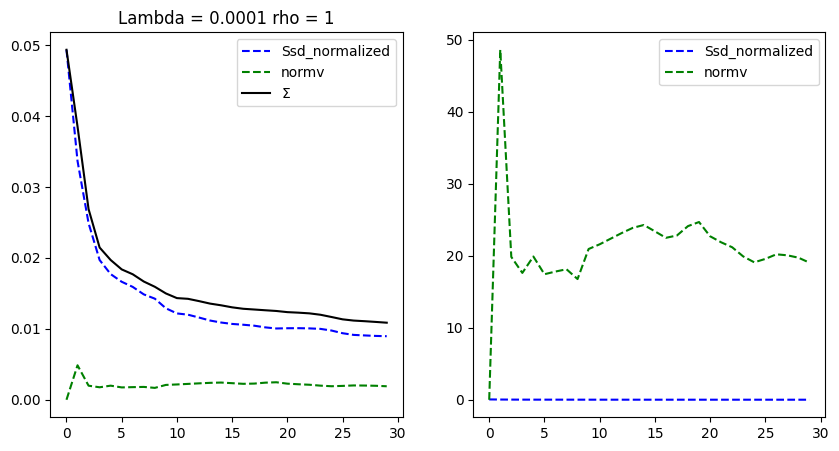

In [126]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1
# rho = 1 - 1e-4
print(rho)

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
data_cost = mt.Ssd_normalized(target)
# data_cost =  None
ic.disable()


mr = mt.simplex_metamorphosis(source,target,momentum_ini,kernelOperator,rho,
                               integration_steps=10,
                               n_iter=30,
                               grad_coef=.2,
                               cost_cst=1e-4,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.952057..1.4180121].


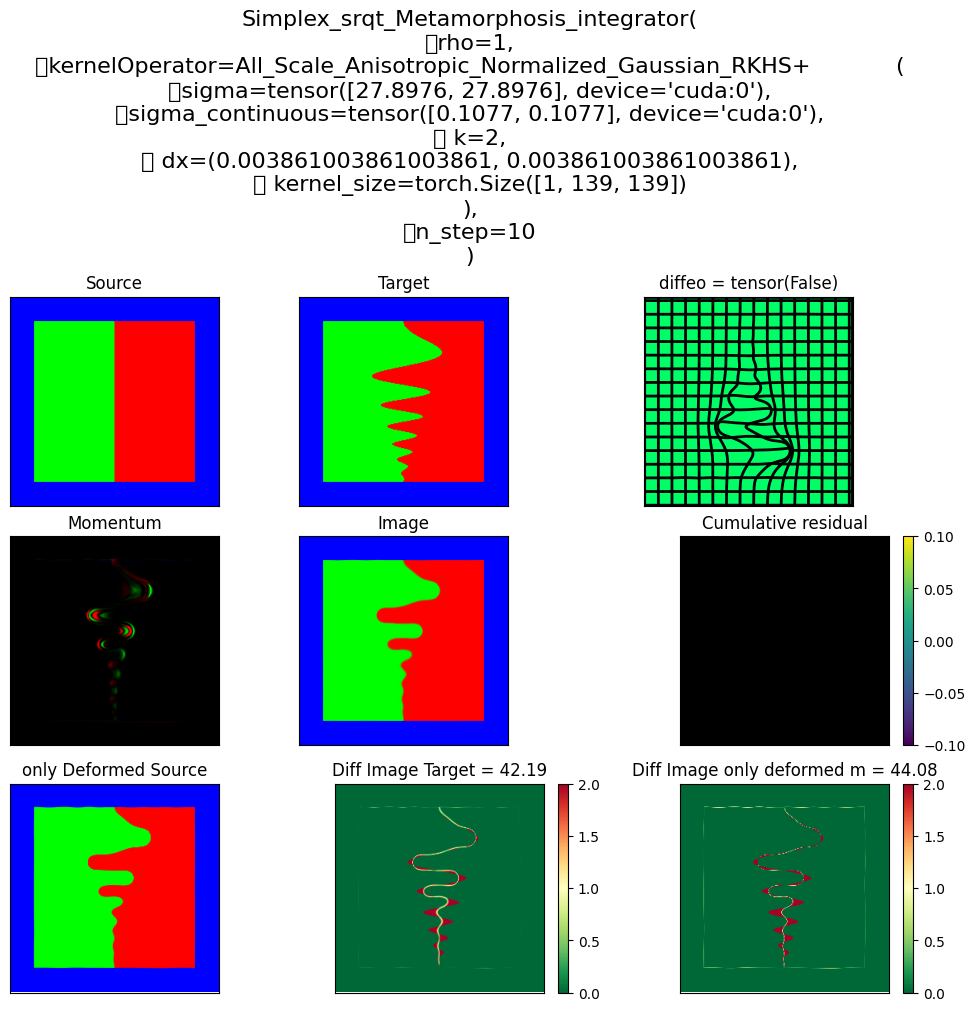

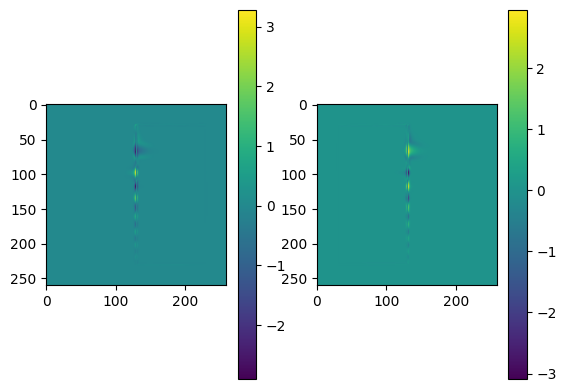

In [124]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])
plt.show()

/tmp/ipykernel_9840/1943387269.py:4: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(deform,step=1,ax= ax,check_diffeo=True, color='black')
/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


(<Axes: title={'center': 'diffeo = tensor(True)'}>,
  <matplotlib.lines.Line2D at 0x7393d0135160>])

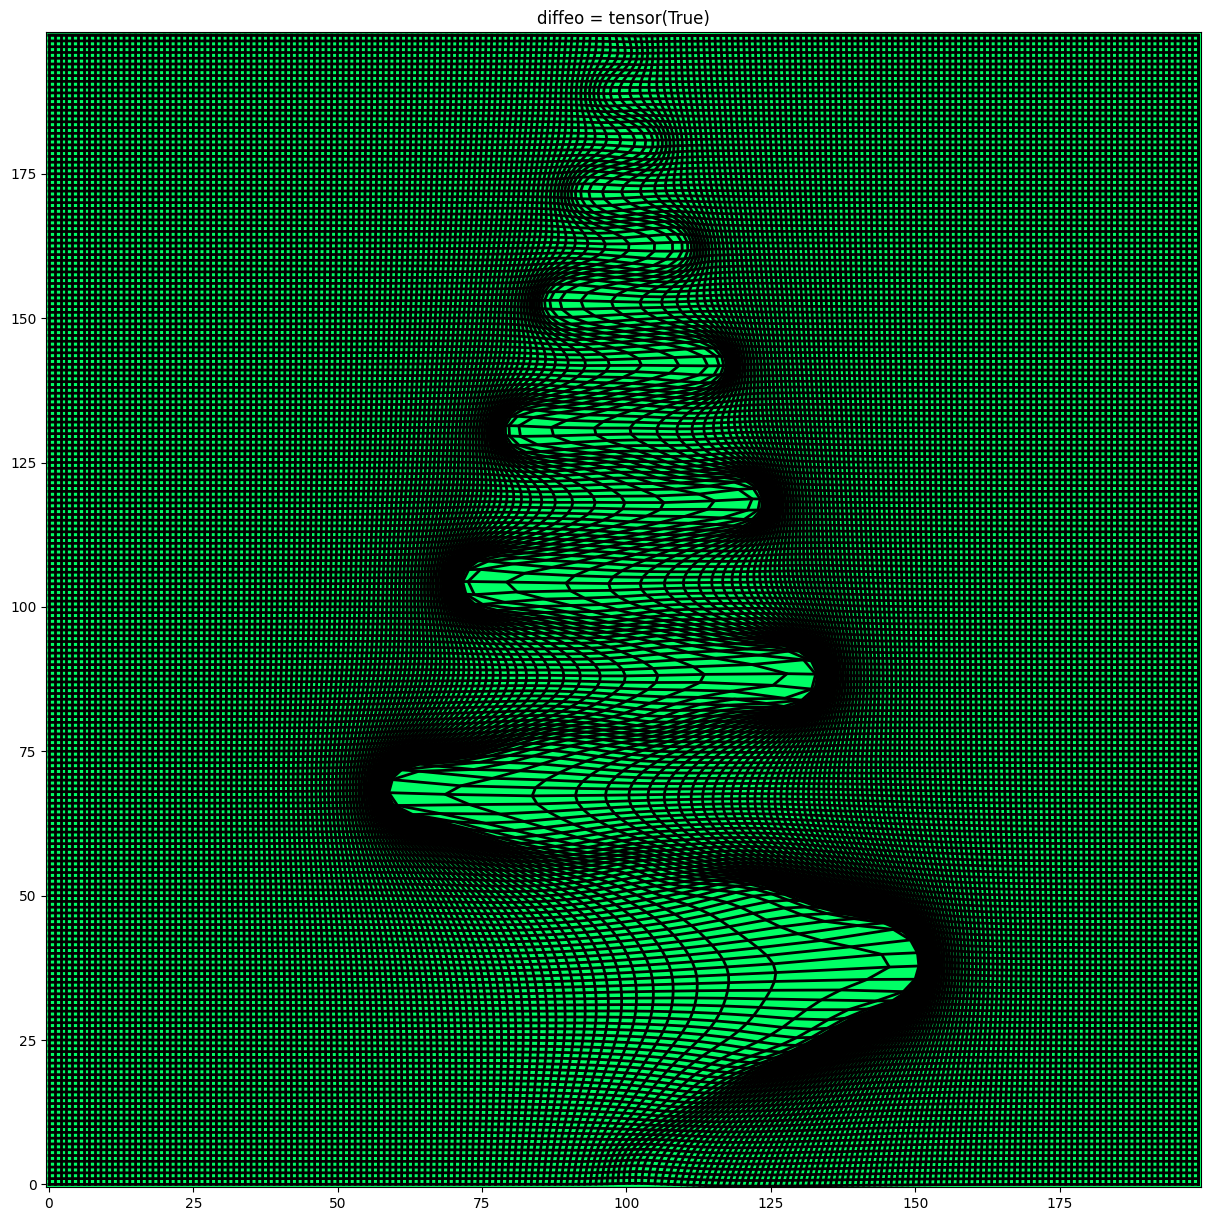

In [14]:
deform =  mr.mp.get_deformation()

fig, ax = plt.subplots(1,1, figsize=(15,15))
tb.gridDef_plot(deform,step=1,ax= ax,check_diffeo=True, color='black')

### Gray scale image



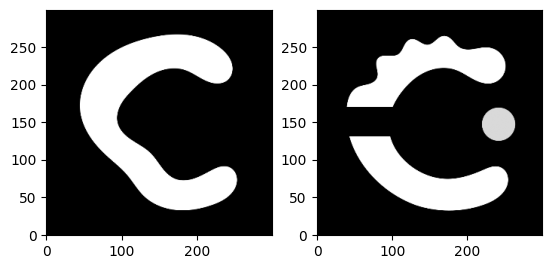

All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([21.4597, 21.4597], device='cuda:0'),
	sigma_continuous=tensor([0.1078, 0.1078], device='cuda:0'),
	 k=4,
	 dx=(0.005025125628140704, 0.005025125628140704),
	 kernel_size=torch.Size([1, 107, 107])
)
Progress: [##########] 100.00% Done...ormalized : ,  0.0022).
 (Ssd_normalized : ,  0.0022).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7397032976150513..1.470715880393982].



Computation of forward done in  0:00:45s and 0.776cents  s

Computation of metamorphosis done in  0:00:45s and 0.776cents  s


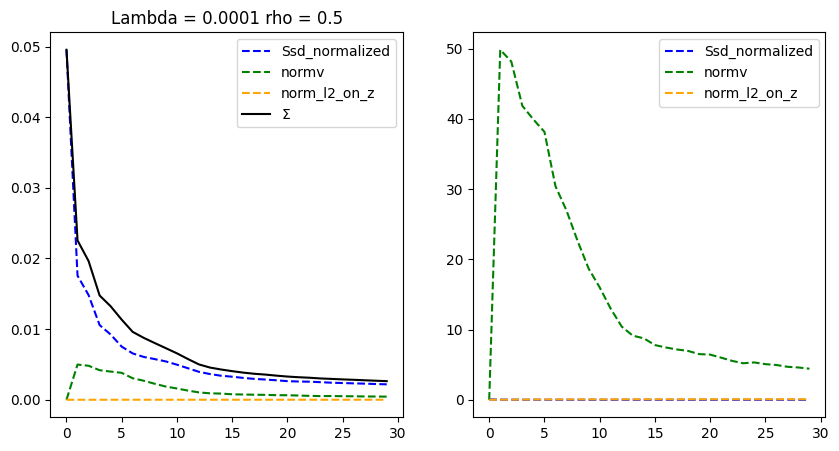

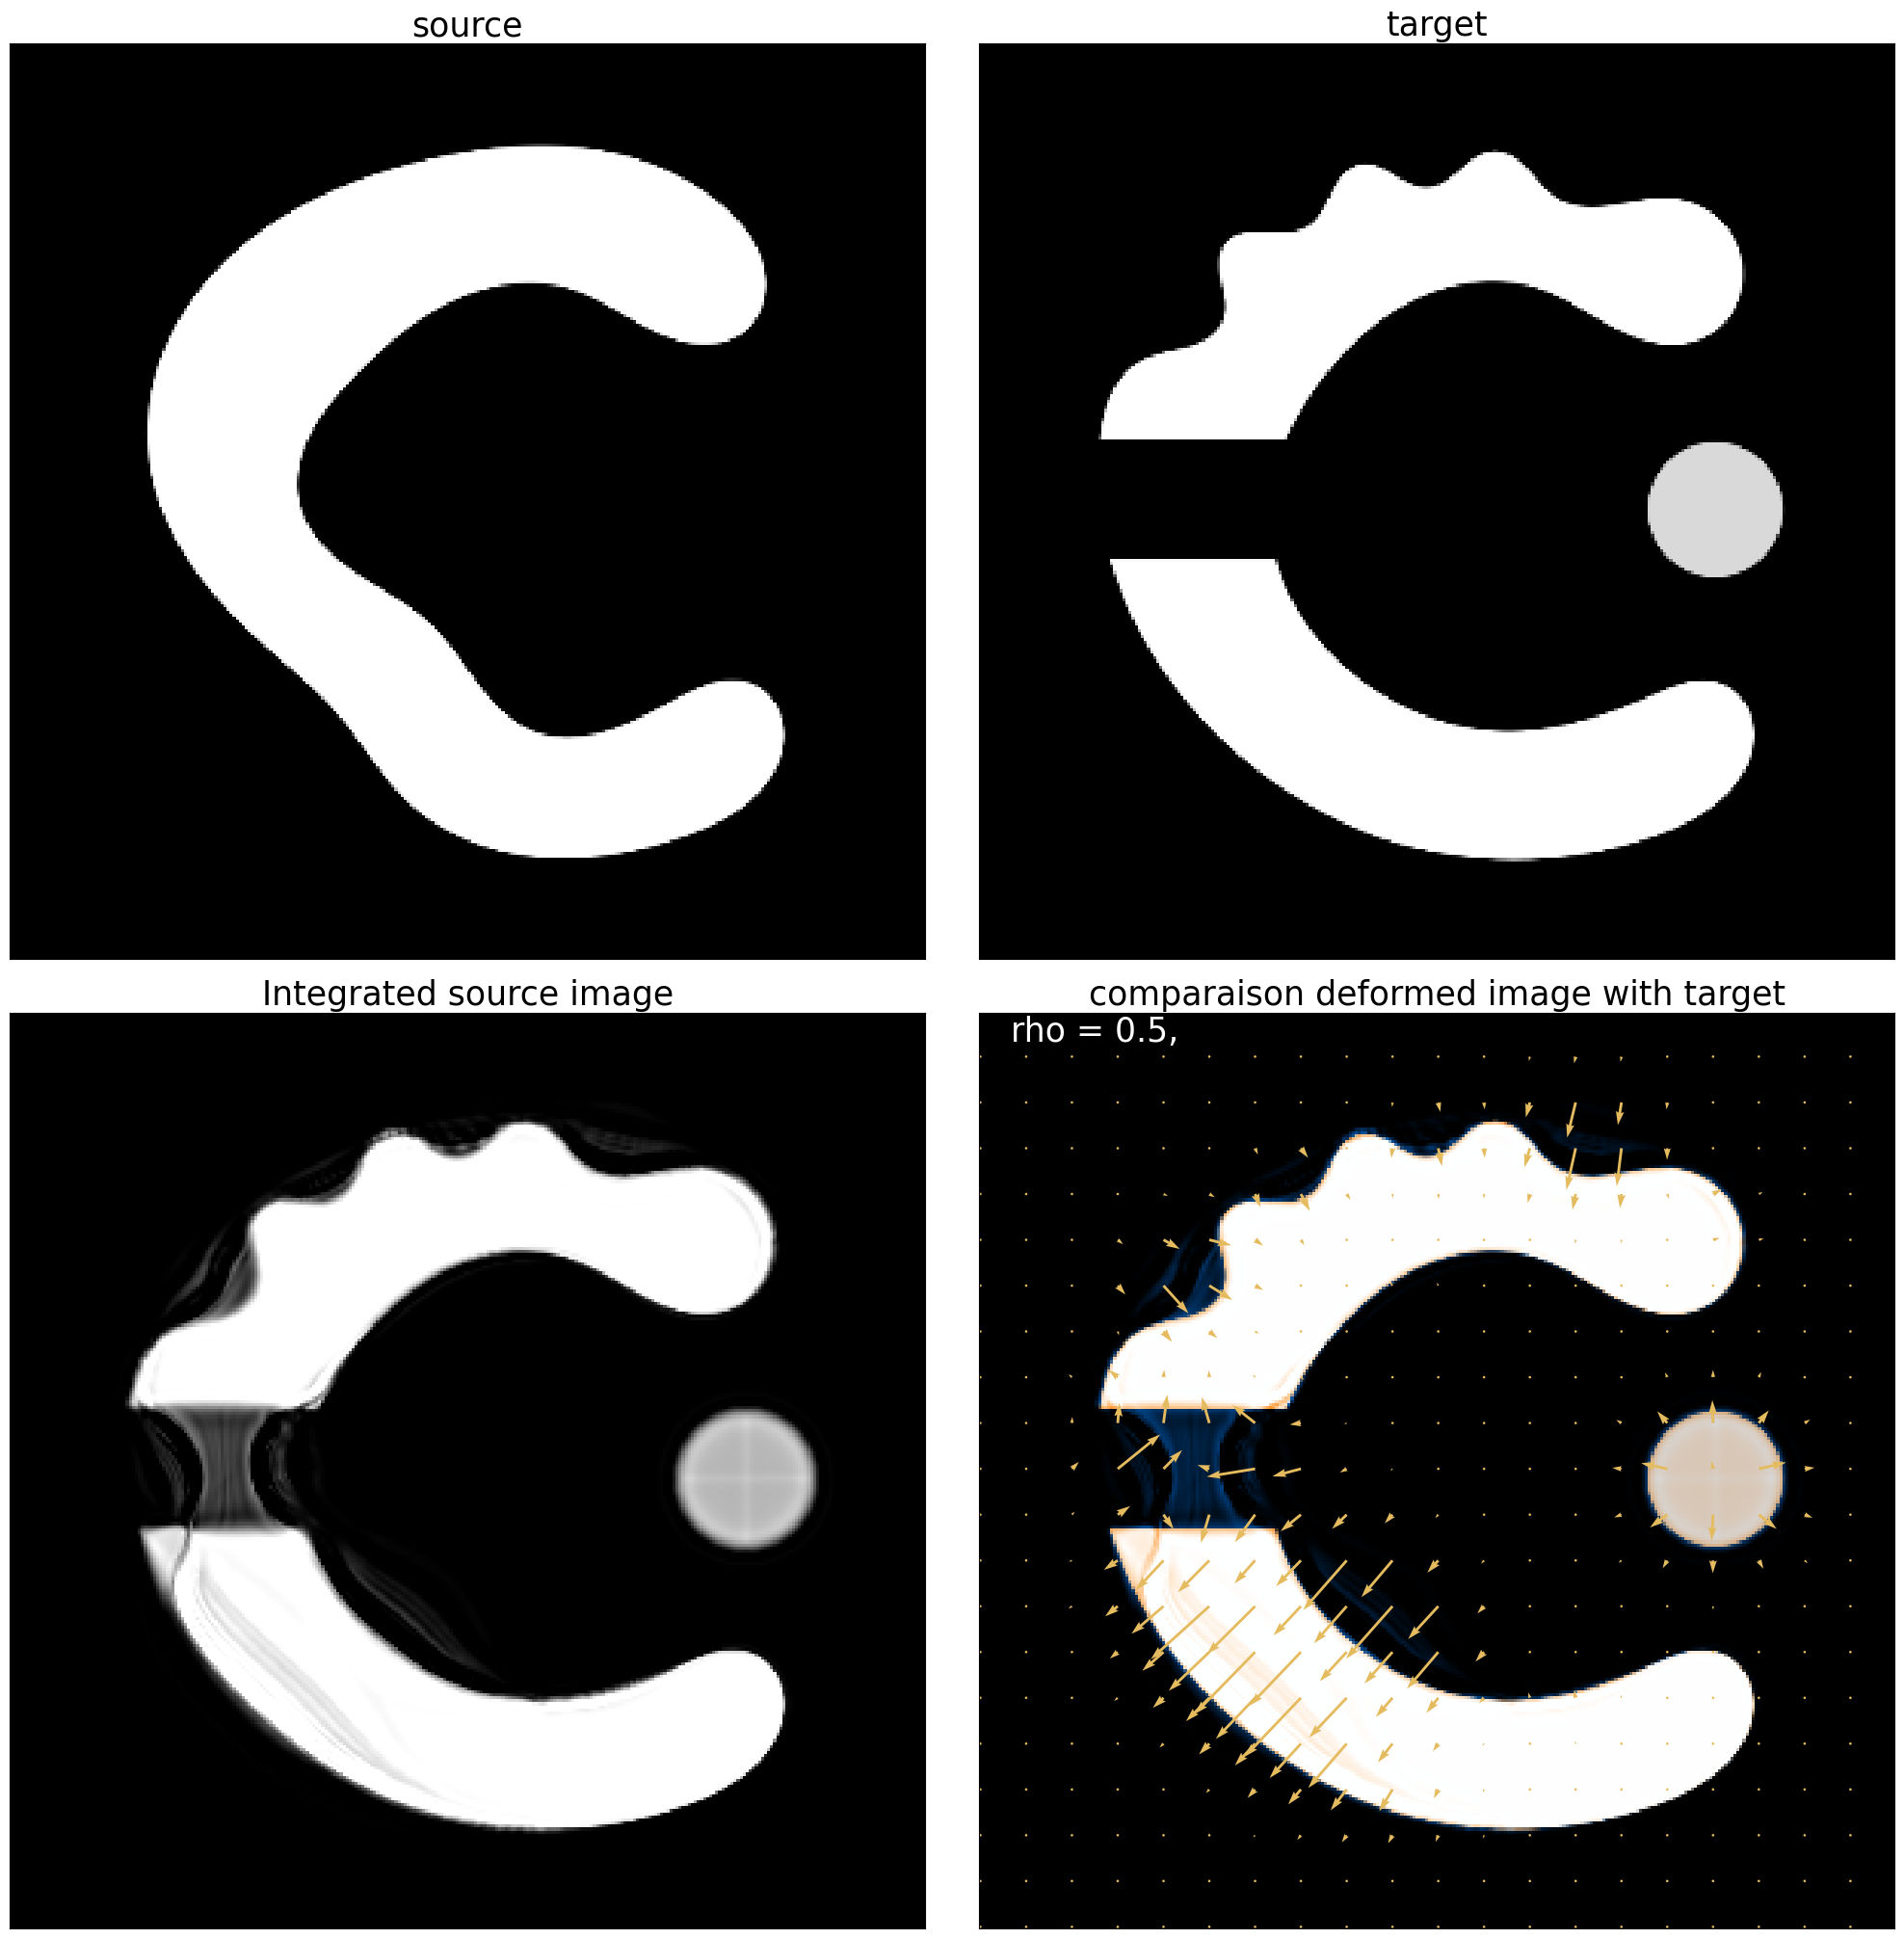

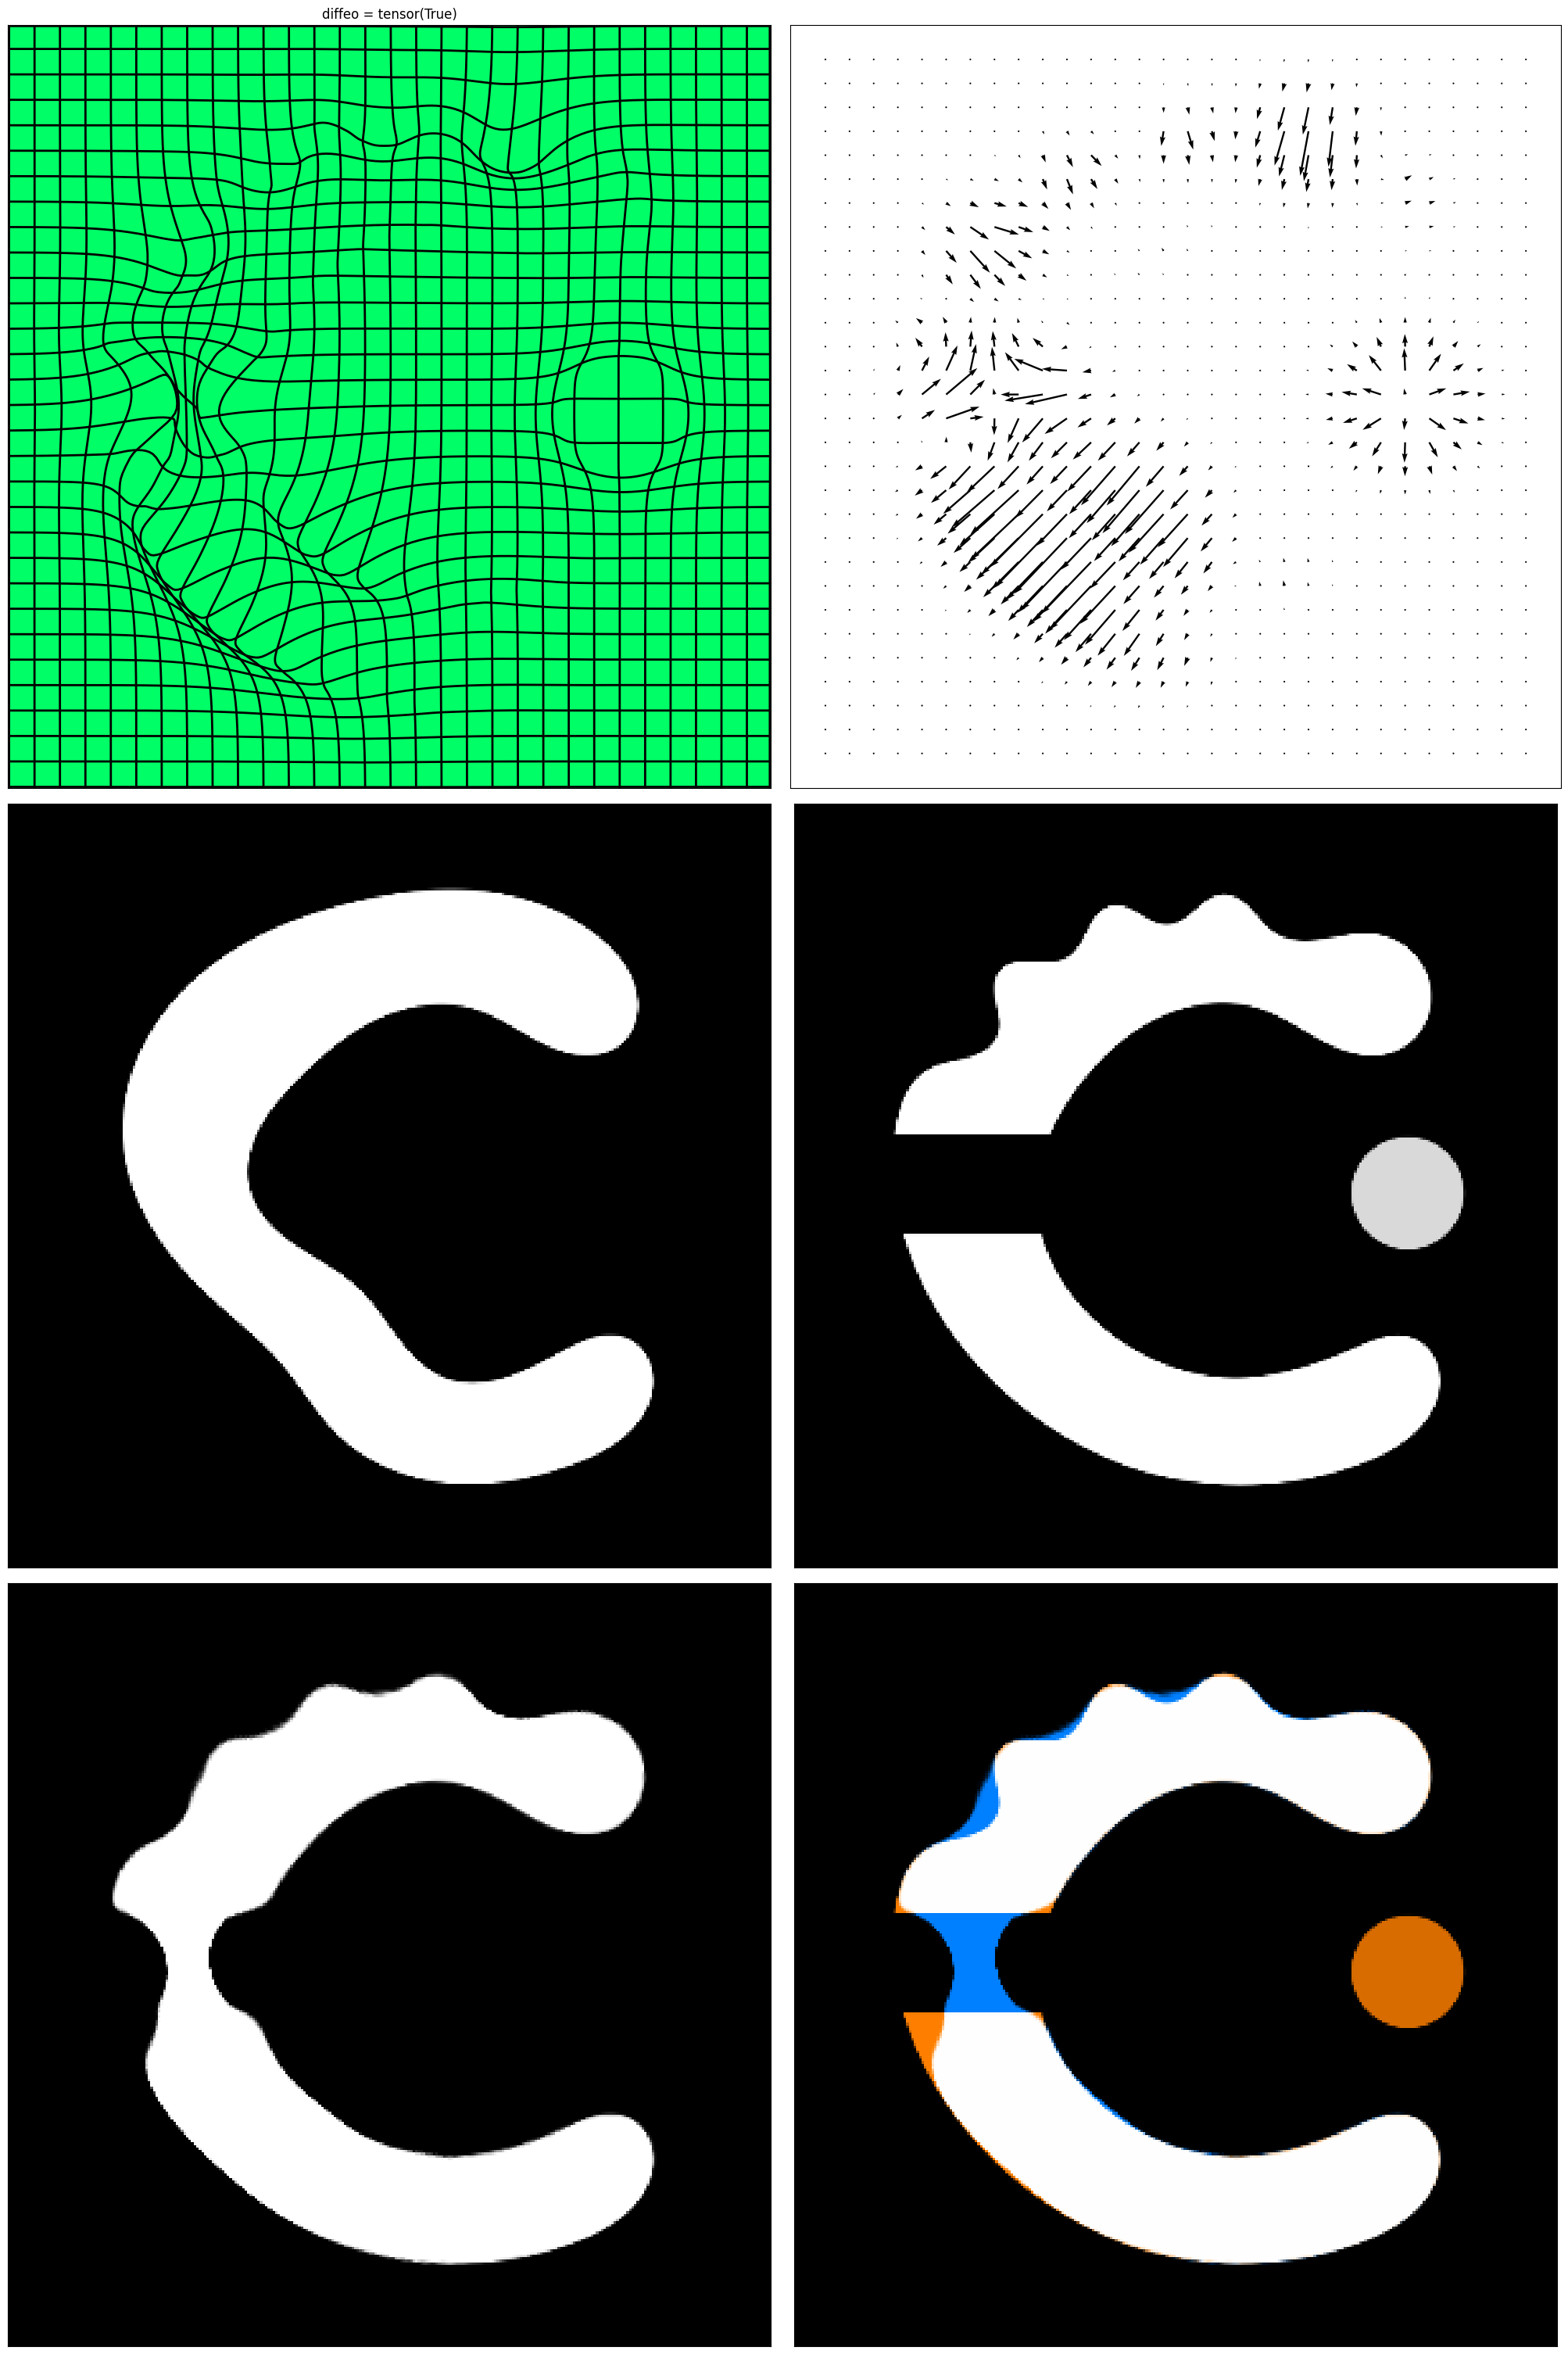

In [115]:
size = (300,300)
source = tb.reg_open('m0t', size=size)
target = tb.reg_open('m1cd', size=size)


fig,ax = plt.subplots(1,2)
ax[0].imshow(source[0,0],**DLT_KW_IMAGE)
ax[1].imshow(target[0,0],**DLT_KW_IMAGE)
# ax[2].imshow((boule - newboule)[0,0])
plt.show()

source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)
data_cost = mt.Ssd_normalized(target)
# data_cost = None
rho = .5

momentum_ini = torch.zeros_like(source)

print(kernelOperator)

mr = mt.metamorphosis(source,
                      target,
                      momentum_ini,
                      rho,
                      cost_cst=.0001,
                      kernelOperator = kernelOperator,
                      integration_steps=5, 
                      data_term = data_cost,
                      n_iter=30,
                        grad_coef=10,
)

mr.plot()
mr.plot_deform()
plt.show()

# Figure

## Faire varier k

tensor(1.)
(0.002506265664160401, 0.005025125628140704)
1

Iteration  1/5 for k = 0.00
(2,)
0 0
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([39.9000, 19.9000]),
	sigma_continuous=tensor([0.1000, 0.1000]),
	 k=0.0,
	 dx=(0.002506265664160401, 0.005025125628140704),
	 kernel_size=torch.Size([1, 199, 99])
)
kernel min max 2.8849044042544847e-07 0.0012594283325597644
Progress: [##########] 100.00% Done...ormalized : ,  0.0165).
 (Ssd_normalized : ,  0.0165).
Computation of forward done in  0:00:50s and 0.614cents  s

Iteration  2/5 for k = 0.75
(2,)
0 0
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([39.9000, 19.9000]),
	sigma_continuous=tensor([0.1000, 0.1000]),
	 k=0.75,
	 dx=(0.002506265664160401, 0.005025125628140704),
	 kernel_size=torch.Size([1, 199, 99])
)
kernel min max 2.8849044042544847e-07 0.0022040007170289755
Progress: [##########] 100.00% Done...ormalized : ,  0.0061).
 (Ssd_normalized : ,  0.0061).
Computation of for

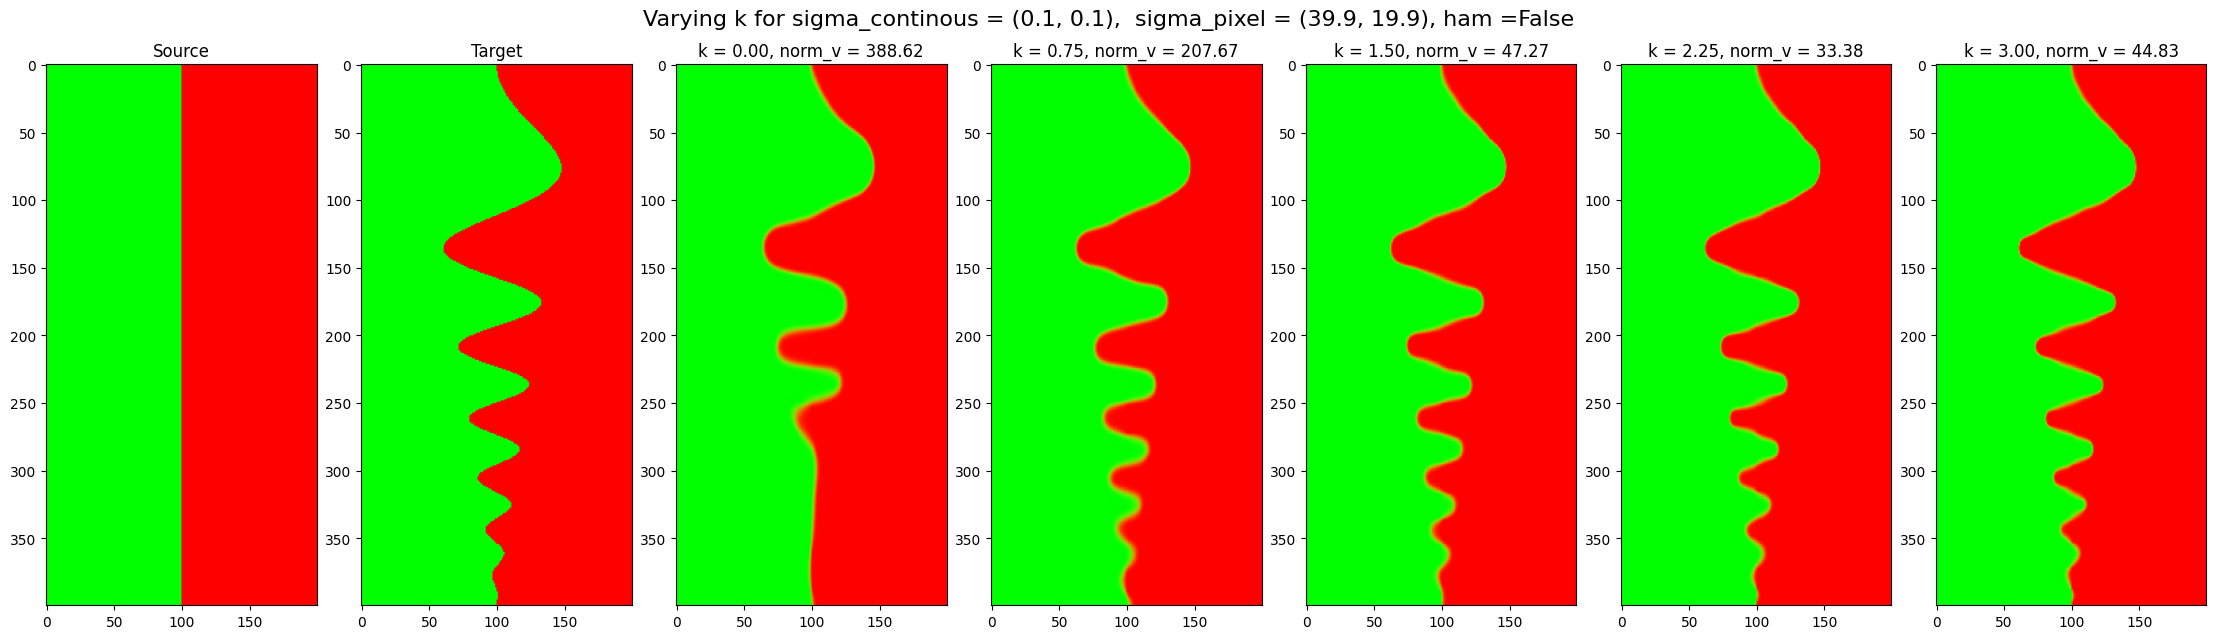

Saving at /home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/examples/results/simplex_result/all_scale_norm/all_scale_norm_vary_k_size(400, 200)_sigma(0.1, 0.1).png


In [18]:
size = (400,200)
dx_convention = 'pixel' 

r = size[1]/size[0]
source,target, name = experience_3(size,.08)
name = "all_scale_norm"
path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)
    
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.07
# sigma = (s,s)
# sigma = (3,9)
# print("diff min max :",kernelOperator.kernel.max().item() - kernelOperator.kernel.min().item())

source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1
# rho = 1 - 1e-4
print(rho)
sigma = (0.1,0.1)
sigma_conv = 'continuous'

# sigma = (21,21)
# sigma_conv = 'pixel'

n_iter = 20
n = 5
he = 8 / 2.54  
k_max = 3


fig, ax = plt.subplots(1,n+2, 
                       figsize=((n+2)*he,he/r),
                       constrained_layout=True)
ax[0].imshow(tp(source))
ax[0].set_title("Source")
ax[1].imshow(tp(target))
ax[1].set_title("Target")

for i,k in enumerate(np.linspace(0,k_max,n)):
    print(f"\nIteration  {i+1}/{n} for k = {k:.2f}")
    kernelOperator = All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
            sigma=sigma,
            sigma_convention=sigma_conv, # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
            k = k,
            dx=dx,
        )
    print(kernelOperator)
    print("kernel min max",kernelOperator.kernel.min().item(), kernelOperator.kernel.max().item())
    
    momentum_ini = torch.zeros_like(source)
    # momentum_ini = mr.to_analyse[0].to('cuda')
    momentum_ini.requires_grad = True
    data_cost = mt.Ssd_normalized(target)
    # data_cost =  None
    ic.disable()
    
    mr = mt.simplex_metamorphosis(source,target,momentum_ini,kernelOperator,rho,
                                   n_step=10,
                                   n_iter=n_iter,
                                   grad_coef=2,
                                   cost_cst=.00001,
                                   plot=False,
                                   data_term = data_cost,
                                   dx_convention = dx_convention,
                                    safe_mode = False,
                                  ham = True
        )
    
    ax[i+2].imshow(tp(mr.mp.image.detach().cpu()))
    ax[i+2].set_title(f"k = {k:.2f}, norm_v = {mr.norm_v_2:.2f}")

sig_p = tuple([round(s.item()*10)/10 for s in kernelOperator.sigma])
sig_c = tuple([round(s.item()*10)/10 for s in kernelOperator.sigma_continuous])

fig.suptitle(f"Varying k for sigma_continous = {sig_c},  sigma_pixel = {sig_p}, ham ={mr.flag_hamiltonian_integration}", fontsize=16)
plt.show()
fig.savefig(f"{path_save}{name}_vary_k_size{size}_sigma{sig_c}.png")
print(f"Saving at {path_save}{name}_vary_k_size{size}_sigma{sig_c}.png")

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 1e-05 rho = 1'}>, <Axes: >],
       dtype=object))

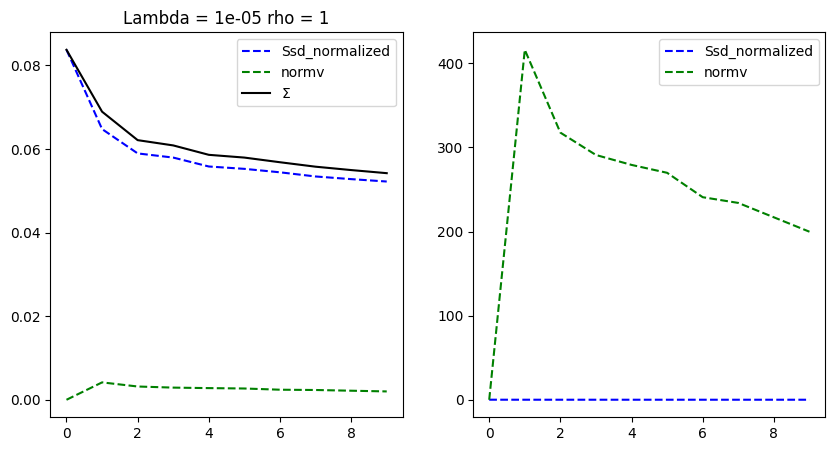

In [15]:
mr.plot_cost()
